In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd

df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [6]:
import cv2
import csv
import math 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import random 
from ipywidgets import interact
from sklearn.preprocessing import Normalizer
import pickle
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import time
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
filename_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OD.sav'
filename_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OC.sav'
model_OD = pickle.load(open(filename_OD, 'rb'))
model_OC = pickle.load(open(filename_OC, 'rb'))
# Open pca and scaler model
filename_pca_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OD.pkl'
filename_scaler_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OD.pkl'
pca_OD = pickle.load(open(filename_pca_OD,'rb'))
scaler_OD = pickle.load(open(filename_scaler_OD, 'rb'))

filename_pca_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OC.pkl'
filename_scaler_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OC.pkl'
pca_OC = pickle.load(open(filename_pca_OC,'rb'))
scaler_OC = pickle.load(open(filename_scaler_OC, 'rb'))

In [8]:
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
template_image = cv2.imread(filename, 0)

In [ ]:
#make image template

plt.rcParams["figure.figsize"] = (5,5)

template_image = np.zeros([551, 551], np.float32)
for i in range(100):
    src = cv2.imread(df['path'][i], 1)
    src = src[:,:,1]
    temp, _ = ekstrakROI(df['disc_center'][i], 550, src)
    template_image += temp

template_image = ((template_image)/100)
template_image = np.uint8(template_image)

filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
cv2.imwrite(filename, template_image)
print(template_image.dtype)
plt.imshow(template_image, cmap = 'gray')
plt.show()

In [2]:
!pip install scikit-image==0.18.1

     |████████████████████████████████| 29.2MB 146kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [3]:
import skimage
print(skimage.__version__)

0.18.1


# Semua Fungsi Algoritma

In [9]:
# menampilkan gambar
def figure(images, title, coloumn = 3, size = 20):
    
    plt.rcParams["figure.figsize"] = (size,size) #memperbesar gambar
    

    if (len(images) < 3):
      col = len(images)
    else:
      col = coloumn*1

    row = math.ceil(len(images)/col)

    for a in range(len(images)):
      plt.subplot(row,col, a+1), plt.imshow(images[a], cmap = 'gray')
      plt.title(title[a])
      plt.xticks([]), plt.yticks([])
    plt.show()

In [10]:
# merubah GT drishti menjadi citra mask ground truth
def drishtiGT(path, shape):

  file = open(path, 'r')
  coordinates = file.readlines()
  h, w, _ = shape

  # Ekstrak koordinat dari file gt drishti
  for i in range(len(coordinates)):
    y, x = coordinates[i].split(" ")
    coordinates[i] = (int(x), int(y))

  coordinates = np.array(coordinates)
  file.close()

  # inisiasi citra mask ground truth

  mask = np.zeros([h, w], np.uint8)
  mask[coordinates[:, 1],coordinates[:, 0]] = 255
  color = 255
  mask_contour, hierarchy = cv2.findContours(mask, 
  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  mask = np.zeros([h, w], np.uint8)
  # menggambar boundary mask dari data coordinate gt drishti

  cv2.drawContours(mask, mask_contour, -1, color, cv2.FILLED)

  return mask



In [11]:
# fungsi untuk mengkonversi groundtruth REFUGE
def refuGT(path):


  #coming soon
  mask = cv2.imread(path, 0)
  h, w = mask.shape

  #inisialisasi bound
  OD_mask = np.zeros([h, w], np.uint8)
  OC_mask = np.zeros([h, w], np.uint8)

  OD_mask[mask==128] = 255
  OC_mask[mask==0] = 255

  OD_mask = OD_mask + OC_mask



  return OD_mask, OC_mask


In [12]:
def maxima(d_img):
# Input : distance map 
# output : max point map (maxima) 
  height, width = d_img.shape

  maxima = np.zeros(d_img.shape, dtype = int)
  th = d_img.max()/2
  maxima[d_img > th] = 255

  return maxima

In [13]:
def extractcentroids(maxima):
  # mencari centroid dari setiap blob maxima
  centroids = []
  contours, hierarchy  = cv2.findContours(maxima,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    # calculate moments for each contour
    M = cv2.moments(c)
    # calculate x,y coordinate of center
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      p = [cX, cY]
      centroids.append(p)
    


  return centroids


In [14]:
# put circle in bright region of retinal image
def brightspot (centroid, img, c=None):
  image = img.copy()
  for i in range(len(centroid)):
    image = cv2.circle(image, (centroid[i][0], centroid[i][1]) , 5, (255, 255, 255), -1)
    if i == c:
      cv2.putText(image, "{}".format(i), (centroid[i][0] - 25, centroid[i][1] - 25),cv2.FONT_HERSHEY_SIMPLEX,3, (255, 255, 255), 4)
    else:
      cv2.putText(image, "{}".format(i), (centroid[i][0] - 25, centroid[i][1] - 25),cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 8)

  return image

In [15]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)

  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = x0 + (-x0)
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = x1 - (x1-(w-1))

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = y0 + (-y0)
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = y1 - (y1-(h-1))

  return y0, y1, x0, x1

In [16]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image


def ekstrakROI(centroid, s, img):

  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1+1, x0:x1+1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [17]:
# Circle Hough Transform Model fitting
def CircleHoughTransform(mask):
  
  gray = cv2.GaussianBlur(mask, (5, 5),0)

  #inisiasi output circle hough transform
  mask_hough = np.zeros(mask.shape, np.uint8)
  
  rows = gray.shape[0]
  circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows/2,
                               param1=100, param2=10,
                               minRadius=100, maxRadius=600)

  # memastikan paling tidak ada satu lingkaran yang terdeteksi
  try: 
    if circles is not None:
      circles = np.round(circles[0, :]).astype("int")
    
      # inisialisasi jarak dan parameter lingkaran
      min_jarak = 9999
      circle = (0,0,0)
      xc, yc = 300, 300
      # seleksi lingkaran dengan jarak pusat lingkaran
      # yang paling dekat dengan titik tengah ROI
      for (x, y, r) in circles:
        jarak = (x - xc)**2 + (y - yc)**2
        if jarak < min_jarak:
          circle = x, y, r
          min_jarak = jarak

      Xc, Yc, R = circle

      cv2.circle(mask_hough, (Xc, Yc), R, 255, thickness = cv2.FILLED)
 
  except:
      mask_hough = mask

  return mask_hough

In [18]:
# fungsi untuk segmentasi OC dan OD mvoulana et al
# Input : Region of Interest of OD
# Output : mask of OD dan OC
def segmentasi_OC_OD_kmeans(ROI):
  # Reshaping the image into a 2D array of pixels and 1 color values (Grayscale)
  pixel_vals = ROI.reshape((-1,1)) 
  

  # Convert to float type 
  pixel_vals = np.float32(pixel_vals)

  #the below line of code defines the criteria for the algorithm to stop running,  
  #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)  
  #becomes 85% 
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 150, 0.95) 
    
  # then perform k-means clustering wit h number of clusters defined as 3 
  #also random centres are initally chosed for k-means clustering 
  k = 5 # dari mvoulana
  retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 

  # convert data into 8-bit values 
  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()] 
  
  # reshape data into the original image dimensions 
  segmented_image = segmented_data.reshape((ROI.shape)) 
  
  # mengambil label dengan nilai value tertinggi pertama dan kedua
  
  centers.sort()
  max_value = max(centers)
  min_value = min(centers)
  second_value = -999
  for i in range(len(centers)):
    if second_value < centers[i] and max_value > centers[i] :
      second_value = centers[i]
  
  first_label = np.where(centers == max_value)[0]
  second_label = np.where(centers == second_value)[0]
  # last_label = np.where(centers == min_value)[0]

  #inisisasi mask OD dan OC
  OD_kmeans = np.zeros(ROI.shape, np.uint8)
  OC_kmeans = np.zeros(ROI.shape, np.uint8)

  # Vessel_mask = np.zeros(ROI.shape, np.uint8)


  labels = labels.reshape((ROI.shape))
  # Mengisi mask OD dan OC 
  h, w = ROI.shape

  OC_kmeans[labels == first_label] = 255
  OD_kmeans[labels == second_label] = 255

  
  OD_kmeans = OD_kmeans + OC_kmeans


  # operasi morfologi
  kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
  OC_mask = cv2.erode(OC_kmeans, kernel,iterations = 1)
  OD_mask = cv2.erode(OD_kmeans, kernel, iterations = 1)

  OC_mask = cv2.dilate(OC_mask,kernel, iterations = 1)
  OD_mask = cv2.dilate(OD_mask, kernel, iterations = 1)

  OC_mask = cv2.erode(OC_mask, kernel,iterations = 1)
  OD_mask = cv2.erode(OD_mask, kernel, iterations = 1)

  OC_mask = cv2.dilate(OC_mask,kernel, iterations = 1)
  OD_mask = cv2.dilate(OD_mask, kernel, iterations = 1)

  #kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(80,80))
  #OC_mask = cv2.morphologyEx(OC_mask, cv2.MORPH_CLOSE, kernel)
  #OD_mask = cv2.morphologyEx(OD_mask, cv2.MORPH_CLOSE, kernel)

  # Convex hull
  OD = OD_mask.copy()
  OC = OC_mask.copy()
  contoursOD, hierarchyOD = cv2.findContours(OD, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contoursOC, hierarchyOC = cv2.findContours(OC, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  OD_convexhull = np.zeros([h, w], np.uint8)
  OC_convexhull = np.zeros([h, w], np.uint8)

  for i in range(len(contoursOD)):
    color = 255
    contoursOD[i] = cv2.convexHull(contoursOD[i], False)
    
    # seleksi contour 
    centers, radius = cv2.minEnclosingCircle(contoursOD[i])
    min_Rad = 50
    if (radius > min_Rad):
      cv2.drawContours(OD_convexhull, contoursOD, i, color, thickness = cv2.FILLED)

  for i in range(len(contoursOC)):
    color = 255
    contoursOC[i] = cv2.convexHull(contoursOC[i], False)
    
    # seleksi contour 
    centers, radius = cv2.minEnclosingCircle(contoursOC[i])
    min_Rad = 25
    if (radius > min_Rad):
      cv2.drawContours(OC_convexhull, contoursOC, i, color, thickness = cv2.FILLED)

  # Circle Hough Transform
  OD_circle = CircleHoughTransform(OD_convexhull)
  OC_circle = CircleHoughTransform(OC_convexhull)

  return OD_circle, OC_circle



In [19]:
def drawMask(mask, src, tipe):

  source  = src.copy()
  idx = np.where(mask == 255)
  idx = list(zip(*idx))
  idx = np.array(idx)

  if tipe == 'kuning':
    source[idx[:, 0], idx[:, 1],0] = 0 #R
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #B

  elif tipe =='biru':
    source[idx[:, 0], idx[:, 1],0] = 0 #R
    source[idx[:, 0], idx[:, 1],1] = 0 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #B

  elif tipe == 'hijau':
    source[idx[:, 0], idx[:, 1],0] = 0 #B
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 0 #R

  elif tipe == 'merah':
    source[idx[:, 0], idx[:, 1],0] = 255 #R
    source[idx[:, 0], idx[:, 1],1] = 0 #G
    source[idx[:, 0], idx[:, 1],2] = 0 #B

  elif tipe == None:
    source[idx[:, 0], idx[:, 1],0] = 0 #B
    source[idx[:, 0], idx[:, 1],1] = 255 #G
    source[idx[:, 0], idx[:, 1],2] = 255 #R

  return source

In [20]:
# mengembalikan size Mask OC dan OD menjadi size citra awal
def resizeMask(koordinat, shape, mask):
  yo, yi, xo, xi = koordinat

  mask_temp = np.zeros(shape, np.uint8)

  for y in range(yo, yi):
    for x in range(xo, xi):
      if mask[y-yo][x-xo] == 255:
        mask_temp[y][x] = 255

  return mask_temp

In [21]:
# Fungsi untuk mengekstrak TP, TN, FP, FN dari input yang berbeda
# input : ground truth dan prediksi. kedua objek tersebut harus sama sizenya (uint8)
# output : TP, TN, FP, FN

def checkROI(OD, center):
  # tipe adalah pembeda cara ekstrak TP, TN, FP, dan FN berbentuk int (1,2,3)
  # tipe : 1. OD detection, 2. segmentasi , 3. screening glaucoma

  # print('coming soon')
  batas = 90
  luasgtAsli = np.sum(OD==255)
  _, (y0, y1, x0, x1) = ekstrakROI(center, 600, OD)
  luasgtROI = np.sum(OD[y0:y1+1, x0:x1+1]==255)
  presentasi = (luasgtROI/ luasgtAsli) * 100

  if presentasi >= batas:
      return True, presentasi
  else:
      return False, presentasi


  


In [22]:
# kalkulasi metrik 
def MetricCalc (gt, pred, tipe):
  # tipe adalah pembeda cara ekstrak TP, TN, FP, dan FN berbentuk int (1,2,3)
  # tipe : 1. untuk OD detection, 2. untuk segmentasi , 3. screening glaucoma
  TP, TN, FP, FN = hitungPred(gt, pred, tipe)

  metrik = {"sen": (TP, (TP+FN)) , "PPV": (TP, TP + FP ), "Fscore" : ((2*TP), (2*TP + FP + FN)), 
            "spe" : ( TN, (TN + FP)), "NPV" : (TN, (TN + FN)),
            "Acc" : ((TP + FN) , ( TP + TN + FP + FN))}

  for hasil in metrik:
    num, denum = metrik[hasil]
    if denum == 0:
      metrik[hasil] = 0
    else :
      metrik[hasil] = round(num/denum, 2)

  return metrik["Fscore"]

In [23]:
def centerofmass(mask):
    contours, _  = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
 
    # calculate moments for each contour
    M = cv2.moments(contours[0])

    # calculate x,y coordinate of center
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        M["m00"] = 0.0000000001
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
    return (cX, cY)
    

In [24]:
def differenceMap(ROI):
  # Membuat 18 Difference map dari ROI
  ROI_rgb = [ROI[:,:,0],ROI[:,:,1], ROI[:,:,2]]
  diffmap = []
  for i in range(3):
    G = ROI_rgb[i].copy()
    gpA = [G]
    for i in range(8):
      G = cv2.pyrDown(G)
      gpA.append(G)


    C = [1,2,3]
    D = [3, 4]
    for c in C:
      for d in D:
        s = c + d
        h, w = gpA[c].shape[:2]
        fs_c = cv2.resize(gpA[s], (w, h), interpolation = cv2.INTER_NEAREST)
      
        m = abs(gpA[c] - fs_c)
        #resize maps back to original size
        m = cv2.resize(m, (ROI.shape[1], ROI.shape[0]), interpolation = cv2.INTER_NEAREST)
        diffmap.append(m)
  
  return diffmap

def extractTag(gt, mask, area = 'OD'):
    percentage = np.sum(gt[mask==255])/ np.sum(mask==255) * 100
    if percentage >= 98 :
      if area == 'OD':
        tag = 'OD' #daerah OD
      elif area == 'OC':
        tag = 'OC'
    else:
      tag = 'Otherwise' #daerah non OD

    return tag

def extractHistSP(label, images,segments):
    mask = np.zeros((images[0].shape[0], images[0].shape[1]),np.uint8)
    mask[segments==label] = 255
    HIST_map = np.zeros((5, 256), np.uint8)
    for i in range(len(images)):
      HIST_map[i, :],_ = np.histogram(images[i][mask==255].ravel(),256,[0,256])

    #normalize histogram
    # hist_normalizer = Normalizer(norm='l1').fit(HIST_map)
    # HIST_map = hist_normalizer.transform(HIST_map)
    return HIST_map

def extractCSS(map, mask):
    CSS_map = np.zeros((18, 2), np.uint8)
    for i in range(len(map)):
      CSS_map[i, 0] = np.sum(map[i][mask==255])/(np.sum(mask==255)) #mu
      CSS_map[i, 1] = np.sum((map[i][mask==255]-CSS_map[-1, 0])**2)/(np.sum(mask==255)) #var
    return CSS_map

def CSS_vecs(mask, segments, map, CSS_map):
      # search SP neighbors

      CSS_vectors = [0, 0, 0, 0, 0]
      CSS_vectors[0] = CSS_map # assign CSS of current SP 
      try:
        cX, cY = centerofmass(mask)
        SP_value = segments[cY, cX]
        edge_point_x = segments.shape[1] 
        edge_point_y = segments.shape[0]

        neighbors_explored = [0, 0, 0, 0] #initiate neigbors_explored value
        all_neighbors_explored = False
        d = 1 # initiate step 

        #print('x = {}'.format(cX))
        #print('y = {}'.format(cY))
        #print('SP_value = {}'.format(SP_value))
        
        # moving coordinates toward neigbors superpixel
        while not all_neighbors_explored:
            # search first neighbor
            #print('d = {}'.format(d))

            if cX + d < edge_point_x:
              if segments[cY, cX + d] != SP_value and neighbors_explored[0] == 0:
                  label = segments[cY, cX + d]
                  mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                  mask_neighbor[segments==label] = 255
                  CSS_vectors[1] = extractCSS(map, mask_neighbor)
                  neighbors_explored[0] = 1

                  #n1 = centerofmass(mask_neighbor)
                  #print('n1 = {}, label = {}'.format(n1, label))

            else:
              neighbors_explored[0] = 1 # handle superpixel on edge of image
              CSS_vectors[1] = np.zeros((18, 2), np.uint8)

              #n1 = (cX,cY)
              

            # search second neigbor
            if cX - d > 0: 
              if segments[cY, cX - d] != SP_value and neighbors_explored[1] == 0:
                label = segments[cY,cX - d]
                
                mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                mask_neighbor[segments==label] = 255
                CSS_vectors[2] = extractCSS(map, mask_neighbor)
                neighbors_explored[1] = 1 # checklist if second neighbor is found
                
                #n2 = centerofmass(mask_neighbor)
                #print('n2 = {}, label = {}'.format(n2, label))
            else:
              
              neighbors_explored[1] = 1 # handle superpixel on edge of image
              CSS_vectors[2] = np.zeros((18, 2), np.uint8)
              
              #n2 = (cX,cY)
            # search third neigbor
            if cY + d < edge_point_y:
              if segments[cY+d, cX] != SP_value and neighbors_explored[2] == 0:
                label = segments[cY+d, cX]
                mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                mask_neighbor[segments==label] = 255
                CSS_vectors[3] = extractCSS(map, mask_neighbor)
                neighbors_explored[2] = 1 # checklist if second neighbor is found
                
                #n3 = centerofmass(mask_neighbor)
                #print('n3 = {}, label = {}'.format(n3, label))
            else:
              neighbors_explored[2] = 1 # handle superpixel on edge of image
              CSS_vectors[3] = np.zeros((18, 2), np.uint8)
              #n3 = (cX,cY)
            # search forth neigbor
            if cY - d > 0 : 
              
              if segments[cY-d, cX] != SP_value and neighbors_explored[3] == 0:
                label = segments[cY-d, cX]

                mask_neighbor = np.zeros((mask.shape[0], mask.shape[1]),np.uint8)
                mask_neighbor[segments==label] = 255
                CSS_vectors[4] = extractCSS(map, mask_neighbor)
                neighbors_explored[3] = 1 # checklist if second neighbor is found
                
                #n4 = centerofmass(mask_neighbor)
                #print('n4 = {}, label = {}'.format(n4, label))
            else:
              neighbors_explored[3] = 1 # handle superpixel on edge of image
              CSS_vectors[4] = np.zeros((18, 2), np.uint8)
              
              #n4 = (cX, cY)
            
            d+= 5 # step of exploration
            
            # if all neigbors explored, then end the exploration
            if 0 not in neighbors_explored:
              all_neighbors_explored = True

        #image = mark_boundaries(ROI, segments)
        #image = segments.copy()
        #image = cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
        #image = cv2.circle(image, n1, 5, (255, 255, 255), -1)
        #cv2.putText(image, "1", n1,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)
        
        #image = cv2.circle(image, n2, 5, (255, 255, 255), -1)
        #cv2.putText(image, "2", n2, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)

        #image = cv2.circle(image, n3, 5, (255, 255, 255), -1)
        #cv2.putText(image, "3", n3,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)

        #image = cv2.circle(image, n4, 5, (255, 255, 255), -1)
        #cv2.putText(image, "4", n4,cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2)
        #plt.imshow(image)
        #plt.show()

        CSS_vectors = np.array(CSS_vectors)
        return CSS_vectors
        
      except:
        print('Problem with finding mask center of mass')
      

In [25]:
def extract_img(ROI):
    # ekstrak citra kanal r, g, b, h dan v sekaligus menerapkan CLAHE untuk kanal rgb
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    r = clahe.apply(ROI[:,:,0])
    g = clahe.apply(ROI[:,:,1])
    b = clahe.apply(ROI[:,:,2])
    ROI = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
    h = ROI[:,:,0]
    s = ROI[:,:,1]
  
    return [r, g, b, h, s]

In [26]:
# Ekstraksi fitur superpixel
def sp_extract_feature4train(ROI, label, segments, gt, area='OD', center_od = None):
  # this function will return features of superpixel input 
  # the features are histogram(HIST) and central surround statistics(CSS)
  # Input criteria
  # 1. RGB format
  # 2. ROI of Optic Disc 550 x 550 pixel
  # 3. Segments image from SLIC
  # Output :
  # Features of superpixel in ROI : HIST and CSS
  # CSS : Ekstrak mean dan std difference map dari setiap SP
  
  # ekstraksi difference map dan ROI pada 5 kanal 
  diffmap = differenceMap(ROI)
  images = extract_img(ROI)
  

  h = images[0].shape[0]
  w = images[0].shape[1]
  # Ekstraksi Fitur HIST dan CSS pada setiap SP
  mask = np.zeros((h, w),np.uint8)
  mask[segments==label] = 255

  # Mendapatkan histogram dari setiap kanal 
  HIST_map = extractHistSP(label, images, segments)

  # menentukan SP adalah daerah OD atau OC atau bukan 
  # Kode dibawah ini hanya dipakai untuk ekstraksi data 
  tag = extractTag(gt, mask, area)

  # Ektraksi CSS pada SP dan 4 tetangganya
  CSS_map = extractCSS(diffmap, mask)
  CSS_vector = CSS_vecs(mask, segments, diffmap, CSS_map)

  # mengkombinasikan seluruh fitur menjadi fitur 1 dimensi
  if area == 'OC':
    xc, yc = center_od
    xj, yj = centerofmass(mask)
    D = np.sqrt(((xc-xj)/h)**2 + ((yc-yj)/w)**2)
    D = np.array([D])
    features = (HIST_map.flatten(), CSS_vector.flatten(), D)
  elif area == 'OD':
    features = (HIST_map.flatten(), CSS_vector.flatten())
  
  combined = np.concatenate(features)
  return combined, tag

  


In [27]:
# Ekstraksi fitur superpixel
def sp_extract_feature(ROI, label, segments, area='OD', center_od=None):
  # this function will return features of superpixel input 
  # the features are histogram(HIST) and central surround statistics(CSS)
  # Input criteria
  # 1. RGB format
  # 2. ROI of Optic Disc 550 x 550 pixel
  # 3. Segments image from SLIC
  # Output :
  # Features of superpixel in ROI : HIST and CSS

  # ekstrak 18x3  difference map dari ROI
  diffmap = differenceMap(ROI)
  
  # ekstrak citra kanal r, g, b, h dan v sekaligus menerapkan CLAHE untuk kanal rgb
  images = extract_img(ROI)

  h = images[0].shape[0] #height of image
  w = images[0].shape[1] # width of image

  # Ekstraksi Fitur HIST dan CSS pada setiap SP
  mask = np.zeros((h, w),np.uint8)
  mask[segments==label] = 255

  # Mendapatkan histogram dari setiap kanal 
  HIST_map = extractHistSP(label, images, segments)

  # menentukan SP adalah daerah OD atau bukan 
  # Kode dibawah ini hanya dipakai untuk ekstraksi data 

  # Ektraksi CSS pada SP dan 4 tetangganya
  CSS_map = extractCSS(diffmap, mask)
  CSS_vector = CSS_vecs(mask, segments, diffmap, CSS_map)

  # mengkombinasikan seluruh fitur menjadi fitur 1 dimensi
  if area == 'OC':
    xc, yc = center_od
    xj, yj = centerofmass(mask)
    D = np.sqrt(((xc-xj)/h)**2 + ((yc-yj)/w)**2)
    D = np.array([D])
    features = (HIST_map.flatten(), CSS_vector.flatten(), D)
  elif area == 'OD':
    features = (HIST_map.flatten(), CSS_vector.flatten())
  
  combined = np.concatenate(features)
  
  return combined

 

In [124]:
def segmentasi_superpiksel(ROI, model, pca=None, scaler=None, area='OD',
                           center_od=None, mask=None, threshold_OD=0.8,
                           threshold_OC =0.5, numSegments = 150, debug=False):
  # Handle localization problem
  try: 
      #SLIC 
      
      sigma = 10
      # clahe
      cliplimit = 2.0
      tilegridsize = (8,8)
      # blur 
      kernelsize = (50,50)
      # active snake
      Alpha = 0.015
      Beta = 10
      Gamma = 0.001
      std = 3


      # inisialisasi image segmentasi
      segmentation = np.zeros((ROI.shape[0], ROI.shape[1]), np.float32)

      if area == 'OD':
          segments = slic(ROI, n_segments=numSegments, sigma=sigma, start_label=1)
          labels = np.unique(segments)

          for label in labels:
              feature = sp_extract_feature(ROI=ROI, label=label, segments=segments,
                                          area=area)
              X = scaler.transform([feature])
              X = pca.transform(X)
              # X = np.array(X).reshape(1, -1, 1)
              predict = model.predict_proba(X)
              segmentation[segments==label] = predict[0][1]

          # Postprocessing
          seg_bin = np.array(segmentation >= threshold_OD, np.uint8)


      elif area == 'OC':
          segments = slic(ROI, n_segments=numSegments, sigma=sigma, mask=mask,
                          start_label=1)
          labels = np.unique(segments)

          for label in labels[1:]:
              feature = sp_extract_feature(ROI=ROI,label=label,segments=segments,
                                          area=area, center_od=center_od)
              X = scaler.transform([feature])
              X = pca.transform(X)
              predict = model.predict_proba(X)
              segmentation[segments==label] = predict[0][1]
            
          
          # Post processing
          seg_bin = np.array(segmentation >= threshold_OC, np.uint8)

      # Select OD contour that is the largest contour
      cnts, _= cv2.findContours(seg_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

      # Ellipse fitting
      ellipse = cv2.fitEllipse(cnts[0])
      elips = np.zeros((ROI.shape[0], ROI.shape[1]),np.uint8)
      if debug==True:
        elips = cv2.ellipse(elips, ellipse, 255)
        ellipsepts,_ =  cv2.findContours(elips, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        ellipsepts = np.array(ellipsepts[0]).squeeze()
        # Active disc
        snake = active_contour(gaussian(ROI, std),ellipsepts, alpha=Alpha, beta=Beta, gamma=Gamma,coordinates='rc')
        cnts = np.array(cnts[0]).squeeze()

        return segmentation, cnts, ellipsepts, snake
      elif debug==False:
        elips = cv2.ellipse(elips, ellipse, 255, cv2.FILLED)
        return elips
      
  except: 
      print('gagal')
      seg_fail = np.zeros((ROI.shape[0], ROI.shape[1]), np.uint8)
      return seg_fail

In [29]:
def bounding_box(image, contour):
  # return bounding box of contour containing in image
  # size of image and contour must same
  c = cv2.approxPolyDP(contour, 3, True)
  rectcontour = cv2.boundingRect(c)
  xo, yo, length, hight = rectcontour
  yi = yo + hight
  xi = xo + length
  koordinat = (yo, yi, xo, xi)
  return image[yo:yi+1, xo:xi+1], koordinat

In [30]:
def CDR_calc(OD_mask, OC_mask):
  c_OD = cv2.findContours(OD_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  c_OD = cv2.approxPolyDP(c_OD[0], 3, True)
  c_OC = cv2.findContours(OC_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  c_OC = cv2.approxPolyDP(c_OC[0], 3, True)
  ver_OD, hor_OD = cv2.boundingRect(c_OD)
  ver_OC, hor_OC = cv2.boundingRect(c_OC)

  VCDR = ver_OC/ ver_OD # vertical CDR
  HCDR = hor_OC/ ver_OD # Horizontal CDR
  ACDR = np.sum(OC_mask == 255)/ np.sum(OD_mask == 255) # Area CDR

  return VCDR, HCDR, ACDR

def ISNT_calc(OD_mask, OC_mask):
  NRR = OD_mask - OC_mask # Neuro Retinal Rim
  

# Testing segmentasi OD dan OC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


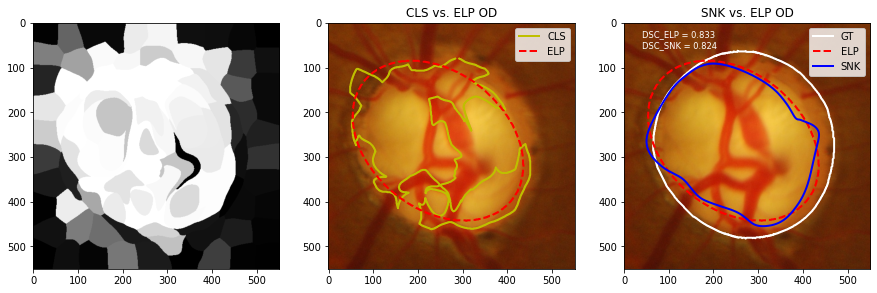

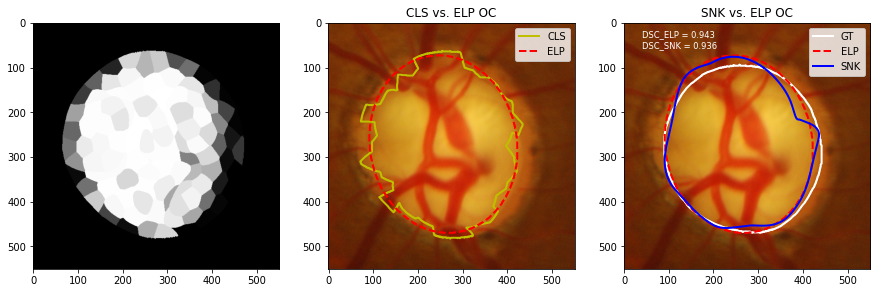

In [125]:
n = 2
plt.rcParams["figure.figsize"] = (5,5)

# load image and ROI 
image = cv2.imread(df['path'][n],1)
ROI, _ = ekstrakROI(df['disc_center'][n], 550, image)
ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)

# load segmentation ground truth of OD and OC
gt_OD = cv2.imread(df['path_OD_png'][n], 0)
gt_OD, _ =  ekstrakROI(df['disc_center'][n], 550, gt_OD)
gt_OC = cv2.imread(df['path_OC_png'][n], 0)
gt_OC, _ =  ekstrakROI(df['disc_center'][n], 550, gt_OC)

# OD and OC segmentation 
# OD segmentation
OD, cnts_OD, ellipse_OD, snake_OD = segmentasi_superpiksel(ROI=ROI,
                                                           model=model_OD,
                                                           pca=pca_OD,
                                                           area='OD',
                                                           scaler=scaler_OD,
                                                           numSegments = 100, 
                                                           threshold_OD=0.98,
                                                           debug=True)

gt_cnts_OD, _ = cv2.findContours(gt_OD, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
gt_cnts_OD = np.array(gt_cnts_OD[0]).squeeze()

# OC segmentation
contour_OD, _ = cv2.findContours(gt_OD, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
contour_OD = sorted(contour_OD, key=cv2.contourArea, reverse=True)
# shrink ROI of OC to fit OD contour
#ROI_OC, _ = bounding_box(ROI_OD, contour_OD[0])
#mask, _ = bounding_box(gt_OD, contour_OD[0])
#gt_OC = bounding_box(gt_OC, contour_OD[0])
center_OD = df['disc_center'][n]
OC, cnts_OC, ellipse_OC, snake_OC = segmentasi_superpiksel(ROI=ROI,
                                                           model=model_OC,
                                                           pca=pca_OC,
                                                           area='OC',
                                                           scaler=scaler_OC,
                                                           center_od=center_OD,
                                                           mask=gt_OD,
                                                           numSegments = 100,
                                                           threshold_OC=0.5,
                                                           debug=True)

gt_cnts_OC, _ = cv2.findContours(gt_OC, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
gt_cnts_OC = np.array(gt_cnts_OC[0]).squeeze()

# calculate DSC 
# DSC of OD
snake_contour_OD = [np.expand_dims(snake_OD, axis = 0).astype('int32')]
ellipse_contour_OD = [np.expand_dims(ellipse_OD, axis = 0)]

ellipses_OD = np.zeros((ROI.shape[0], ROI.shape[1]), np.uint8)
snakes_OD = np.zeros((ROI.shape[0], ROI.shape[1]), np.uint8)
cv2.drawContours(ellipses_OD, ellipse_contour_OD, -1, 255, cv2.FILLED)
cv2.drawContours(snakes_OD, snake_contour_OD, -1, 255, cv2.FILLED)
DSC_ELP_OD = np.sum(ellipses_OD[gt_OD==255])*2.0 / (np.sum(gt_OD) + np.sum(ellipses_OD))
DSC_SNK_OD = np.sum(snakes_OD[gt_OD==255])*2.0 / (np.sum(gt_OD) + np.sum(snakes_OD))

# DSC of OC
snake_contour_OC = [np.expand_dims(snake_OC, axis = 0).astype('int32')]
ellipse_contour_OC = [np.expand_dims(ellipse_OC, axis = 0)]

ellipses_OC = np.zeros((ROI.shape[0], ROI.shape[1]), np.uint8)
snakes_OC = np.zeros((ROI.shape[0], ROI.shape[1]), np.uint8)
cv2.drawContours(ellipses_OC, ellipse_contour_OC, -1, 255, cv2.FILLED)
cv2.drawContours(snakes_OC, snake_contour_OC, -1, 255, cv2.FILLED)
DSC_ELP_OC = np.sum(ellipses_OC[gt_OC==255])*2.0 / (np.sum(gt_OC) + np.sum(ellipses_OC))
DSC_SNK_OC = np.sum(snakes_OC[gt_OC==255])*2.0 / (np.sum(gt_OC) + np.sum(snakes_OC))

fig1, ax1 = plt.subplots(1, 3, figsize= (15, 5))
ax1[0].imshow(OD, cmap = 'gray')
ax1[1].imshow(ROI)
#plt.plot(gt_cnts[:, 0], gt_cnts[:, 1], 'w', lw=2, label='GT')
ax1[1].plot(cnts_OD[:, 0], cnts_OD[:, 1], 'y', lw=2, label='CLS')
ax1[1].plot(ellipse_OD[:, 0], ellipse_OD[:, 1], 'r--', lw=2, label='ELP')
#plt.plot(snake[:, 0], snake[:, 1], 'b', lw=2, label='SNK')
ax1[1].legend()
ax1[1].set(title='CLS vs. ELP OD')
ax1[2].imshow(ROI)
ax1[2].plot(gt_cnts_OD[:, 0], gt_cnts_OD[:, 1], 'w', lw=2, label='GT')
ax1[2].plot(ellipse_OD[:, 0], ellipse_OD[:, 1], 'r--', lw=2, label='ELP')
ax1[2].plot(snake_OD[:, 0], snake_OD[:, 1], 'b', lw=2, label='SNK')
ax1[2].set(title='SNK vs. ELP OD')
ax1[2].legend()
ax1[2].text(40, 30, 'DSC_ELP = {}'.format(round(DSC_ELP_OD,3)), fontsize='small', color ='w')
ax1[2].text(40, 55, 'DSC_SNK = {}'.format(round(DSC_SNK_OD,3)), fontsize='small', color='w')
  
fig2, ax2 = plt.subplots(1, 3, figsize= (15, 5))
ax2[0].imshow(OC, cmap = 'gray')
ax2[1].imshow(ROI)
#plt.plot(gt_cnts[:, 0], gt_cnts[:, 1], 'w', lw=2, label='GT')
ax2[1].plot(cnts_OC[:, 0], cnts_OC[:, 1], 'y', lw=2, label='CLS')
ax2[1].plot(ellipse_OC[:, 0], ellipse_OC[:, 1], 'r--', lw=2, label='ELP')
#plt.plot(snake[:, 0], snake[:, 1], 'b', lw=2, label='SNK')
ax2[1].legend()
ax2[1].set(title='CLS vs. ELP OC')
ax2[2].imshow(ROI)
ax2[2].plot(gt_cnts_OC[:, 0], gt_cnts_OC[:, 1], 'w', lw=2, label='GT')
ax2[2].plot(ellipse_OC[:, 0], ellipse_OC[:, 1], 'r--', lw=2, label='ELP')
ax2[2].plot(snake_OC[:, 0], snake_OC[:, 1], 'b', lw=2, label='SNK')
ax2[2].set(title='SNK vs. ELP OC')
ax2[2].legend()
ax2[2].text(40, 30, 'DSC_ELP = {}'.format(round(DSC_ELP_OC,3)), fontsize='small', color ='w')
ax2[2].text(40, 55, 'DSC_SNK = {}'.format(round(DSC_SNK_OC,3)), fontsize='small', color='w')
  
plt.show()

# **5. Evaluasi**

**Creation of template histogram**

In [ ]:
# Upload template histogram

file = open('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/template histogram.csv', 'r')

with file:
  read = csv.reader(file)
  hist = list(read)
  histogram_temp = [int(float(x[0])) for x in hist]
  histogram_template = [0] + histogram_temp

file.close()

uint8


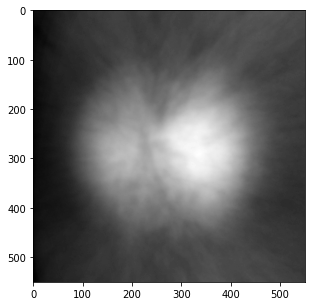

In [ ]:
#make image template

plt.rcParams["figure.figsize"] = (5,5)
drishti_idx = np.arange(0,50)
refuge_idx = np.arange(50,450)
random.Random(4).shuffle(drishti_idx)
random.Random(4).shuffle(refuge_idx)
splitdrishti = 50
splitrefuge = 50
idx = np.concatenate((drishti_idx[:splitdrishti], refuge_idx[:splitrefuge]))

template_image = np.zeros([550, 550], np.float32)
for i in idx:
    src = cv2.imread(df['path'][i], 1)
    src = src[:,:,1]
    clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
    src = clahe.apply(src)
    temp, _ = ekstrakROI(df['disc_center'][i], 550, src)
    template_image += temp

template_image = ((template_image)/(splitdrishti+splitrefuge))
template_image = np.uint8(template_image)


print(template_image.dtype)
plt.imshow(template_image, cmap = 'gray')
plt.show()

In [ ]:
template_image.shape

(551, 551)

In [ ]:
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
cv2.imwrite(filename, template_image)

True

In [ ]:
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/ROItemplate.png'
template_image = cv2.imread(filename, 0)

In [ ]:
  """
  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 8/3

  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)

  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)

  # Ekstrak centroid berpotensi sebagai disc center
  centers = extractcentroids(maxima_img)
  src = brightspot (centers, src)
  
  disk_center = image_template_matching(centers, 550, cl_img, template_image)
  """

In [33]:
# inisialisasi list metrik dan parameter
detection = []
percent_detection = []
Fscore_OD = []
Fscore_OC = []
fitur = []
prediksi = []
fail_OD = []
fail_OC = []
fail_detection = []
plt.rcParams["figure.figsize"] = (20,20)
iterates = len(df)
n = 1

In [ ]:
for i in tqdm(range(0, iterates), desc = 'In Process :D'):

  # input image dan ground truth
  path = df["path"][i]
  path_OD = df["path_OD_png"][i]
  path_OC = df["path_OC_png"][i]

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  result = cv2.matchTemplate(cl_img, template_image, cv2.TM_CCOEFF_NORMED)
  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

  (startX, startY) = maxLoc
  endX = startX + template_image.shape[1]
  endY = startY + template_image.shape[0]
  disk_center = (round((endX+startX)/2), round((endY+startY)/2))

  
  # draw the bounding box on the image
  ROI, koordinat = ekstrakROI(disk_center, 550, src)

  #
  ### Segmentasi OD dan OC ##############################################
  # OD_mask, OC_mask = segmentasi_OC_OD_kmeans(ROI)
  # OD segmentation
  OD_mask = segmentasi_superpiksel(ROI=ROI, model=model_OD, pca=pca_OD, area='OD',
                                   scaler=scaler_OD, threshold_OD=0.8, 
                                   numSegments=100)

  # OC segmentation
  
  OC_mask= segmentasi_superpiksel(ROI=ROI, model=model_OC, pca=pca_OC, area='OC',
                                  scaler=scaler_OC, center_od=disk_center,
                                  mask=OD_mask, threshold_OC =0.5, 
                                  numSegments=100)
  ### Ekstraksi Fitur ###################################################
  


  ### Klasifikasi Glaukoma ##############################################



  ### Perhitungan Metrik ################################################

  # resize mask dan boundary

  OD_mask = resizeMask(koordinat, cl_img.shape, OD_mask)
  OC_mask = resizeMask(koordinat, cl_img.shape, OC_mask)

  deteksi, percentage= checkROI(OD_mask_gt, disk_center)
  detection.append(deteksi)
  percent_detection.append(percentage)
  # Mengecek hasil segmentasi OD dan OC
  Fscore_OD.append(np.sum(OD_mask[OD_mask_gt==255])*2.0 / (np.sum(OD_mask) + np.sum(OD_mask_gt)))
  Fscore_OC.append(np.sum(OC_mask[OC_mask_gt==255])*2.0 / (np.sum(OC_mask) + np.sum(OC_mask_gt)))

  # Mengecek hasil lokalisasi

  if deteksi==False:
    fail_detection.append(i)
    print('Localization failed {}'.format(i))
  if len(np.unique(OD_mask)) == 1:
    fail_OD.append(i)
    print('OD failed to segmented {}'.format(i))
  if len(np.unique(OC_mask)) == 1:
    fail_OC.append(i)
    print('OC failed to segmented'.format(i))

  if i == n*100:
    result = pd.DataFrame({"detection_rate":detection,
                           "percent_detection" : percent_detection,
                           "Fscore_OD": Fscore_OD, "Fscore_OC":Fscore_OC})
    result.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')
    n+=1


result = pd.DataFrame({"detection_rate":detection,
                           "percent_detection" : percent_detection,
                           "Fscore_OD": Fscore_OD, "Fscore_OC":Fscore_OC})
result.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')


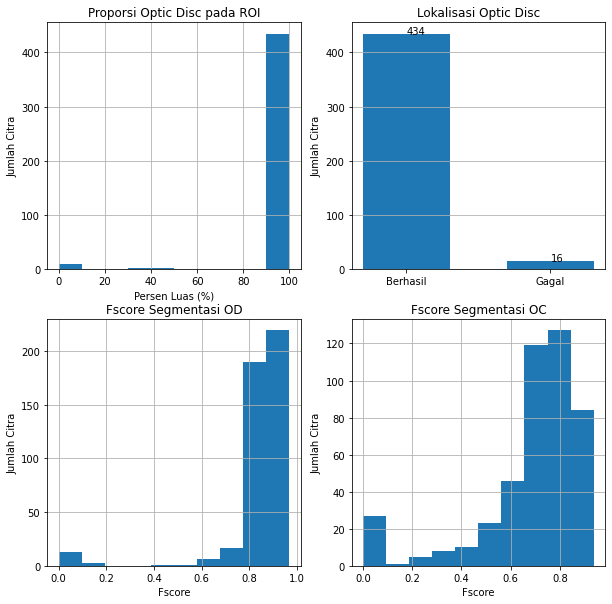

In [36]:

plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(2,2,1), plt.hist(result['percent_detection'], bins = 10)
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Persen Luas (%)')
plt.title('Proporsi Optic Disc pada ROI')

count_true = sum(result['detection_rate'] == True)
count_false = sum(result['detection_rate'] == False)
label = ('Berhasil', 'Gagal')
lokalisasi = (count_true, count_false)
x_coords = np.array([0, 0.5])
plt.subplot(2,2,2), plt.bar(x_coords, lokalisasi,  tick_label = label, width = 0.3)
plt.grid(axis ='y')
plt.text(x_coords[0], count_true, '{}'.format(count_true), fontsize='medium' )
plt.text(x_coords[1], count_false, '{}'.format(count_false), fontsize='medium' )
plt.ylabel('Jumlah Citra')
plt.title('Lokalisasi Optic Disc')

plt.subplot(2,2,3), plt.hist(result['Fscore_OD'], bins = 10)
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Fscore')
plt.title('Fscore Segmentasi OD')

plt.subplot(2,2,4), plt.hist(result['Fscore_OC'], bins = 10)
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Fscore')
plt.title('Fscore Segmentasi OC')
plt.show()

In [39]:
round(result.describe(), 2)

percent_detection  Fscore_OD  Fscore_OC
count             450.00     450.00     450.00
mean               96.96       0.83       0.69
std                16.26       0.17       0.22
min                 0.00       0.00       0.00
25%               100.00       0.83       0.64
50%               100.00       0.87       0.74
75%               100.00       0.90       0.82
max               100.00       0.97       0.94

In [ ]:
@interact(i=range(len(df['path'])))
def roi(i = indeks[0]):

  # input image dan ground truth
  path = df["path"][i]
  path_OD = df["path_OD_png"][i]
  path_OC = df["path_OC_png"][i]

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  
  h, w = src.shape[:2]
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  ### Lokalisasi OD ######################################################
  """
  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 8/3

  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)

  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)

  # Ekstrak centroid berpotensi sebagai disc center
  centers = extractcentroids(maxima_img)
  src = brightspot (centers, src)

  #mask = np.zeros([h, w], np.uint8)
  # Build mask for template matching
  #for center in centers:
  #  y0, y1, x0, x1 = rectfromcenter(center, 550, h, w)
  #  cv2.rectangle(mask, (x0, y0), (x1, y1), 255, thickness = cv2.FILLED)
  """
  result = cv2.matchTemplate(cl_img, template_image, cv2.TM_SQDIFF_NORMED, mask)
  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

  
  #disk_center = image_template_matching(centers, 550, cl_img, template_image)
  #_, koordinat = ekstrakROI(disk_center, 550, cl_img)
  #(startY, endY, startX, endX) = koordinat
  endX = startX + template_image.shape[1]
  endY = startY + template_image.shape[0]
  disk_center = (round((endX+startX)/2), round((endY+startY)/2))
  cv2.rectangle(src, (startX, startY), (endX, endY), (255, 0, 0), 3)

  deteksi, percentage = checkROI(OD_mask_gt, disk_center)
  # draw the bounding box on the image
  ROI_gt, koordinat = ekstrakROI(disk_center, 550, OD_mask_gt)
  plt.figure(figsize=(12, 24))
  plt.subplot(1,2,1)
  plt.imshow(ROI_gt, cmap='gray')
  plt.text(50, 50, '{} %'.format(round(percentage, 2)), fontsize='medium', color = 'y' )
  plt.subplot(1,2,2), plt.imshow(src)

  plt.show()


interactive(children=(Dropdown(description='i', options=(1, 5, 6, 8, 11, 14, 23, 28, 32, 38, 39, 40, 53, 62, 6…

In [ ]:
# Fungsi untuk menyocokan histogram
# input : list koordinat centroid, panjang sisi ROI, citra retina asli, 
# template histogram
# output : koordinat centroid yang diduga centroid dari Optic Disc
def image_template_matching(centroids, s, img, T):
  # img : image
  # R : Correlation formula
  # T : Template image
  R_max = -999
  center = []
  # h, w = img.shape
  # hist_temp = np.array(hist_temp)
  """
  if not centroids:
    result = cv2.matchTemplate(img, T, cv2.TM_SQDIFF_NORMED)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

    (startX, startY) = minLoc
    endX = startX + template_image.shape[1]
    endY = startY + template_image.shape[0]
    center = (round((endX+startX)/2), round((endY+startY)/2))
  """
  korelasi = []
  #else:
  for i in range(len(centroids)):
      centroid = centroids[i]

      #cropping ROI from source image
      I, _ = ekstrakROI(centroid, s, img)

      # Green channel histogram, 0 : red, 1 : green, 2 : blue
      # hist = cv2.calcHist(ROI, [1], None, [256], [0,256])
      # hist = np.array(hist)
      
      #calc correlation formula
      R = np.sum(T * I)/ np.sqrt(np.sum(T**2) * np.sum(I**2)) # TM_COEFF_NORMED
      korelasi.append(R)
      if R > R_max :
        R_max = R
        center = centroid
  print(centroids)
  print(korelasi)
  print('Korelasi : {}'.format(R_max))
  print('centroid : {}'.format(center))
  return center

In [ ]:
result = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')
result.head()

detection_rate  percent_detection  Fscore_OD  Fscore_OC
0               0           0.000000   0.000000   0.000000
1               1         100.000000   0.576139   0.899253
2               1          96.606051   0.000000   0.000000
3               1         100.000000   0.000000   0.000000
4               0           0.000000   0.000000   0.000000

In [ ]:
result['detection_rate'] = result['detection_rate'] + 1 - 1
result.sample(n=10)
result.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json')

detection_rate  percent_detection  Fscore_OD  Fscore_OC
422               1              100.0   0.000000   0.000000
449               1              100.0   0.827263   0.000000
83                1              100.0   0.895886   0.682602
179               1              100.0   0.542150   0.429184
17                1              100.0   0.000000   0.646321
314               1              100.0   0.000000   0.723115
338               1              100.0   0.848434   0.000000
352               1              100.0   0.631350   0.578274
15                1              100.0   0.623724   0.000000
134               1              100.0   0.473330   0.000000

In [ ]:
indeks = result.index[result['detection_rate'] == 0].tolist()
print(indeks)

[6, 38, 40, 47, 96, 169, 195, 226, 261, 263, 308, 356, 385, 387, 404, 411, 428]


In [ ]:
round(result.describe().iloc[[1, 2, 3, 7]], 2)

AttributeError: ignored

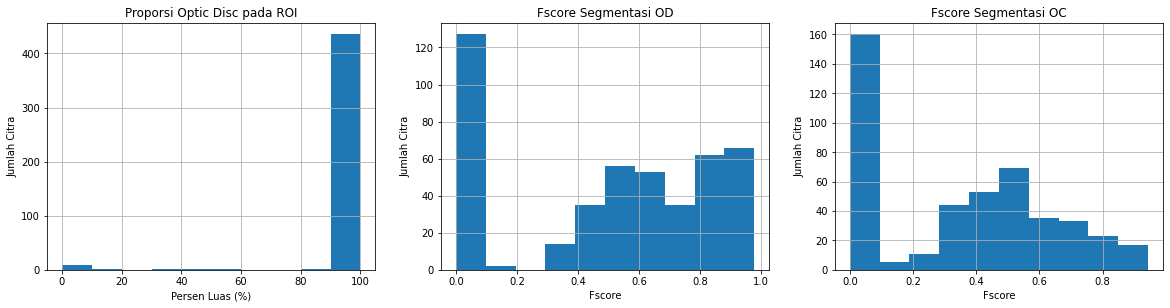

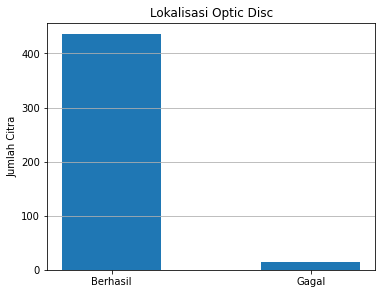

In [ ]:


plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1), plt.hist(result['percent_detection'], bins = 10)
plt.grid()
plt.ylabel('Jumlah Citra')
plt.xlabel('Persen Luas (%)')
plt.title('Proporsi Optic Disc pada ROI')

"""
  plt.subplot(2,3,2), plt.hist(result['Fscore_OD'], bins = 10)
  plt.grid()
  plt.ylabel('Jumlah Citra')
  plt.xlabel('Fscore')
  plt.title('Fscore Segmentasi OD')

  plt.subplot(2,3,3), plt.hist(result['Fscore_OC'], bins = 10)
  plt.grid()
  plt.ylabel('Jumlah Citra')
  plt.xlabel('Fscore')
  plt.title('Fscore Segmentasi OC')
  plt.show()

  count_true = sum(result['detection_rate'] == 1)
  count_false = sum(result['detection_rate'] == 0)
  label = ('Berhasil', 'Gagal')
  lokalisasi = (count_true, count_false)
  x_coords = np.arange(2)
"""

plt.subplot(1,2,4), plt.bar(x_coords, lokalisasi,  tick_label = label, width = 0.5)
plt.grid(axis ='y')
plt.ylabel('Jumlah Citra')
plt.title('Lokalisasi Optic Disc')
plt.show()

In [ ]:
count = sum(result['percent_detection'] < 90)
print(count)

15


In [ ]:
print(indeks[5])

24


In [ ]:

plt.rcParams["figure.figsize"] = (15,15)
@interact(n = (0, len(indeks)-1))
def deteksi(n=0):
# for i in indeks[n]:
  # n = random.randint(1, 150)
  i = indeks[n]
  #image = df['path_OD_png'][i]
  src = cv2.imread(df['path'][i], 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  #src = cv2.imread(image, 1)
  #src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  ### Lokalisasi OD ######################################################

  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 7/3

  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)

  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)
  
  # Ekstrak centroid berpotensi sebagai disc center
  centers = centroids(maxima_img)
  bright_img = brightspot(centers, src)
  
  # Histogram template matching
  s = 600 # ukuran ROI s * s
  diskCenter = histogram_template_matching(centers, s, cl_img,
                                            histogram_template)


  ROI, koordinat = ekstrakROI(diskCenter, s, src)
  hist = cv2.calcHist(ROI, [1], None, [256], [0,256])
  hist_temp = np.array(histogram_template)/max(histogram_template)
  hist = np.array(hist)/max(hist)

  diff = hist - hist_temp
  diff = diff**2
  diff = np.sum(diff)
  corr = 1/(1+diff)
  
  plt.subplot(3,3,1),plt.imshow(bright_img)
  plt.title("brightspot")
  plt.subplot(3,3,2),plt.imshow(cl_img, cmap = 'gray')
  plt.title("CLAHE")
  plt.subplot(3,3,3),plt.imshow(otsu_img, cmap = 'gray')
  plt.title("Otsu thresholding")
  plt.subplot(3,3,4),plt.imshow(dist_img, cmap = 'gray')
  plt.title("distance image")
  plt.subplot(3,3,5),plt.imshow(maxima_img, cmap = 'gray')
  plt.title("maxima")
  plt.subplot(3,3,6),plt.imshow(ROI)
  plt.title("ROI")
  plt.subplot(3,3,7),plt.plot(hist_temp)
  plt.title("histogram template")
  plt.subplot(3,3,8),plt.plot(hist)
  plt.title("Histogram ROI")

  plt.tight_layout()
  plt.show()
  print("correlation : {:.8f}".format(corr))



In [ ]:
from skimage.segmentation import slic, felzenszwalb
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from ipywidgets import interact
import cv2
import random 

plt.rcParams["figure.figsize"] = (20,8)
index = []
for i in range(len(indeks)):
  
  n = random.randint(1, 150)

  #image = df['path_OD_png'][i]
  src = cv2.imread(df['path'][i], 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  #src = cv2.imread(image, 1)
  #src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  ### Lokalisasi OD ######################################################

  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 8/3

  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,th,255,cv2.THRESH_BINARY)
  retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 

  # convert data into 8-bit values 
  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()] 
  
  # reshape data into the original image dimensions 
  segmented_image = segmented_data.reshape((ROI.shape)) 
  
  # mengambil label dengan nilai value tertinggi pertama dan kedua
  
  centers.sort()
  max_value = max(centers)
  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)
  
  # Ekstrak centroid berpotensi sebagai disc center
  centers = centroids(maxima_img)
  if centers == []:
    index.append(i)

  
  # Histogram template matching
  s = 600 # ukuran ROI s * s
  diskCenter = histogram_template_matching(centers, s, cl_img,
                                            histogram_template)

  
  # Ekstrak ROI
  ROI, koordinat = ekstrakROI(diskCenter, s, src)

  numSegments = 100
  segments = slic(ROI, n_segments = numSegments, sigma = 10)
  #segments_fz = felzenszwalb(ROI, scale=100, sigma=5, min_size=50)


  #ROI = cv2.cvtColor(ROI, cv2.COLOR_RGB2GRAY)
  ROI3 = mark_boundaries(ROI, segments)
  #plt.subplot(2,5,i+1), plt.imshow(ROI3)

#plt.show()

# Aquiring data: Ekstraksi fitur superpixel





In [ ]:
def gray2rgb(gray_image):
  h, w = gray_image.shape
  rgb_image = np.zeros((h, w, 3), np.uint8)
  rgb_image[:, :, 0] = gray_image
  rgb_image[:, :, 1] = gray_image
  rgb_image[:, :, 2] = gray_image
  return rgb_image

In [ ]:
#Ekstraksi fitur Superpixel

tags_OD = []
tags_OC = []
combined_features_OD = []
combined_features_OC = []
index_refuge = list(range(50, 450))
index_drishti = list(range(0, 50))
random.Random(5).shuffle(index_refuge)
random.Random(5).shuffle(index_drishti)
idx_refuge = index_refuge[:80]
idx_drishti = index_drishti[:20]
idx = np.concatenate((idx_refuge, idx_drishti))

In [ ]:
for i in tqdm(idx, desc = 'Ekstraksi fitur Superpiksel: '):
  center_OD = df['disc_center'][i]
  image = cv2.imread(df['path'][i], 1)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ROI, _ = ekstrakROI(center_OD, 550, image)
  gt_OD, _ = ekstrakROI(center_OD, 550, cv2.imread(df['path_OD_png'][i], 0))
  gt_OC, _ = ekstrakROI(center_OD, 550, cv2.imread(df['path_OC_png'][i], 0))

  gt_OD_rgb = gray2rgb(gt_OD)
  gt_OC_rgb = gray2rgb(gt_OC)
  

  numSegments = 100
  segments_OD = slic(gt_OD_rgb, n_segments = numSegments, sigma = 1, 
                     start_label = 1)
  segments_OC = slic(gt_OC_rgb, n_segments = numSegments, sigma = 1, mask=gt_OD,
                     start_label = 1)
  labels_OD = np.unique(segments_OD)
  labels_OC = np.unique(segments_OC)
  max_len = max([len(labels_OD), len(labels_OC)])

  for i in range(max_len):
    if max_len == len(labels_OD):
      cf_OD, tag_OD = sp_extract_feature4train(ROI, labels_OD[i], segments_OD,
                                               gt_OD, area = 'OD')
      combined_features_OD.append(cf_OD)
      tags_OD.append(tag_OD)
      if i < len(labels_OC):
        if labels_OC[i] > 1: # skipping first label in slic OC
          cf_OC, tag_OC = sp_extract_feature4train(ROI, labels_OC[i], segments_OC,
                                                  gt_OC, area = 'OC',
                                                  center_od= center_OD)
          combined_features_OC.append(cf_OC)
          tags_OC.append(tag_OC)
    
    if max_len == len(labels_OC):
      if labels_OC[i] > 1: # skipping first label in slic OC
        cf_OC, tag_OC = sp_extract_feature4train(ROI, labels_OC[i], segments_OC,
                                                  gt_OC, area = 'OC',
                                                  center_od= center_OD)
        combined_features_OC.append(cf_OC)
        tags_OC.append(tag_OC)
      if i < len(labels_OD) :
        cf_OD, tag_OD = sp_extract_feature4train(ROI, labels_OD[i], segments_OD,
                                                 gt_OD, area = 'OD')
                                                 
        combined_features_OD.append(cf_OD)
        tags_OD.append(tag_OD)
        
    



In [ ]:
sp_df_OD = pd.DataFrame({'combined_feature': pd.Series(combined_features_OD), 'tag':pd.Series(tags_OD)})
sp_df_OC = pd.DataFrame({'combined_feature': pd.Series(combined_features_OC), 'tag':pd.Series(tags_OC)})

In [ ]:
sp_df_OD.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OD_100.json')
sp_df_OC.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OC_100.json')

In [32]:
sp_df_OD = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OD_100.json')
sp_df_OC = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpiksel_OC_100.json')

In [ ]:
sp_df_OC.head()

combined_feature        tag
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise

In [ ]:
sp_df_OD['tag'].value_counts()

Otherwise    8348
OD           4376
Name: tag, dtype: int64

In [ ]:
sp_df_OC.head()

combined_feature        tag
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Otherwise

In [ ]:
sp_df_OC['tag'].value_counts()

Otherwise    8785
OC           4951
Name: tag, dtype: int64


# Exploratory Data Analysis for SP

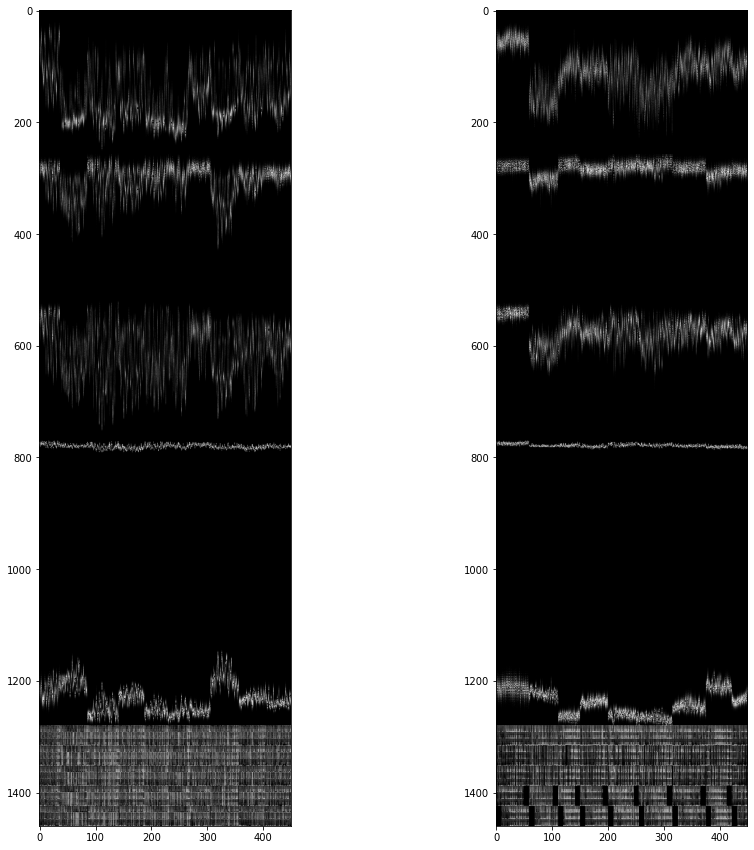

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
feature_map_OD = []
feature_map_nonOD = []
for i in range(450):
  feature_map_OD.append(np.concatenate((OD_df['HIST'][i].flatten(), OD_df['CSS_vec'][i].flatten())))
  feature_map_nonOD.append(np.concatenate((nonOD_df['HIST'][i].flatten(), nonOD_df['CSS_vec'][i].flatten())))
feature_map_OD = np.array(feature_map_OD).T
feature_map_nonOD = np.array(feature_map_nonOD).T
plt.subplot(121), plt.imshow(feature_map_OD, cmap='gray')
plt.subplot(122),plt.imshow(feature_map_nonOD, cmap='gray')
plt.show()

In [ ]:
def var_segment_OD(numSegments, sigma, ROI, segments_OD, contour_OD):
  segments_OD = slic(ROI, n_segments = numSegments, sigma = sigma, start_label = 1)
  OD_segment = mark_boundaries(ROI, segments_OD)
  OD_segment = cv2.drawContours(OD_segment, contour_OD, 0, (1, 1, 1), 1)
  return OD_segment

def var_segment_OC(numSegments, sigma, ROI, segments_OC, contour_OC, mask):
  segments_OC = slic(ROI, n_segments = numSegments, sigma = sigma, mask=mask, start_label = 1)
  OC_segment = mark_boundaries(ROI, segments_OC)
  OC_segment = cv2.drawContours(OC_segment, contour_OC, 0, (1, 1, 1), 1)
  return OC_segment

In [ ]:
OD_idx = [x for x in range(len(sp_df_OD)) if sp_df_OD['tag'][x]=='OD']
non_OD_idx = [x for x in range(len(sp_df_OD)) if sp_df_OD['tag'][x]=='Otherwise']
OC_idx = [x for x in range(len(sp_df_OC)) if sp_df_OC['tag'][x]=='OC']
non_OC_idx = [x for x in range(len(sp_df_OC)) if sp_df_OC['tag'][x]=='Otherwise']

In [ ]:
@interact(OD=OD_idx, non_OD=non_OD_idx, OC=OC_idx, non_OC=non_OC_idx)

def histogram(OD=0, non_OD=0, OC=0, non_OC=0):
  # Check feature histogram
  feature_OD = sp_df_OD['combined_feature'][OD]
  feature_non = sp_df_OD['combined_feature'][non_OD]
  scaled_feature_OD = scaler_OD.transform([feature_OD])
  scaled_feature_non = scaler_OD.transform([feature_non])

  # Check feature histogram
  feature_OC = sp_df_OC['combined_feature'][OC]
  feature_non_C = sp_df_OC['combined_feature'][non_OC]
  scaled_feature_OC = scaler_OC.transform([feature_OC])
  scaled_feature_non_C = scaler_OC.transform([feature_non_C])

  fig, ax = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(15, 10))
  ax[0, 0].plot(feature_OD, color='b', label='OD')
  ax[0, 0].plot(feature_non, color='r', label='non OD')
  ax[0, 0].set(title='feature OD')
  ax[0, 0].legend()
  ax[0, 1].plot(scaled_feature_OD[0], color='b', label='OD')
  ax[0, 1].plot(scaled_feature_non[0], color='r', label='non OD')
  ax[0, 1].set(title='scaled feature OD')
  ax[0, 1].legend()

  ax[1, 0].plot(feature_OC, color='b', label='OC')
  ax[1, 0].plot(feature_non_C, color='r', label='non OC')
  ax[1, 0].set(title='feature OC')
  ax[1, 0].legend()
  ax[1, 1].plot(scaled_feature_OC[0], color='b', label='OC')
  ax[1, 1].plot(scaled_feature_non_C[0], color='r', label='non OC')
  ax[1, 1].set(title='scaled feature OC')
  ax[1, 1].legend()


  plt.show()


interactive(children=(Dropdown(description='OD', options=(22, 23, 24, 28, 33, 34, 35, 36, 42, 43, 44, 45, 46, …

# Training model with PCA

In [33]:
# Separating out the features
X_OD = sp_df_OD['combined_feature'].tolist()
# Separating out the target
y_OD = sp_df_OD['tag'].tolist()

# Separating out the features
X_OC = sp_df_OC['combined_feature'].tolist()
# Separating out the target
y_OC = sp_df_OC['tag'].tolist()


In [34]:
def encoder(data):
  length_data = len(data)
  encoded = []
  for i in range(length_data):
    if data[i] == 'Otherwise':
      encoded.append(-1)
    else:
      encoded.append(1)

  return encoded

In [35]:
# encoding labels of OD
y_OD = encoder(y_OD)

# encoding labels of OC
y_OC = encoder(y_OC)

In [36]:
from sklearn.model_selection import train_test_split

X_train_OD, X_test_OD, y_train_OD, y_test_OD = train_test_split(
    X_OD, y_OD,test_size=0.1, stratify=y_OD)

X_train_OC, X_test_OC, y_train_OC, y_test_OC = train_test_split(
    X_OC, y_OC,test_size=0.1, stratify=y_OC)


In [37]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
scaler_OD = StandardScaler()
scaler_OC = StandardScaler()

scaler_OD.fit(X_train_OD)
scaler_OC.fit(X_train_OC)

# scalling training and testing OD data (mean = 0, std = 1)
X_train_OD = scaler_OD.transform(X_train_OD)
X_test_OD = scaler_OD.transform(X_test_OD)

# scalling training and testing OC data (mean = 0, std = 1)
X_train_OC = scaler_OC.transform(X_train_OC)
X_test_OC = scaler_OC.transform(X_test_OC)

In [38]:
# fit pca model to training data
var = 0.91 # desired retaining variance 
pca_OD = PCA(var) 
pca_OC = PCA(var) 
pca_OD.fit(X_train_OD)
pca_OC.fit(X_train_OC)
X_train_OD = pca_OD.transform(X_train_OD)
X_test_OD = pca_OD.transform(X_test_OD)
X_train_OC = pca_OC.transform(X_train_OC)
X_test_OC = pca_OC.transform(X_test_OC)

In [39]:
# model OD training using data with principal component
model_OD = svm.SVC(kernel='rbf', probability=True)
model_OD.fit(X_train_OD, y_train_OD)

# model OC training using data with principal component
model_OC = svm.SVC(kernel='rbf', probability=True)
model_OC.fit(X_train_OC, y_train_OC)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [40]:
# tells how good OD model is

predictions_train = model_OD.predict(X_train_OD)
start = time.time()
predictions_test = model_OD.predict(X_test_OD)
end = time.time()
scores = model_OD.decision_function(X_test_OD)

train_acc = accuracy_score(predictions_train, y_train_OD)
test_acc = accuracy_score(predictions_test, y_test_OD)

print('Metric for OD superpixel classification')
print('Accuracy train : {} %'.format(round(train_acc*100), 2))
print('Accuracy dev : {} %'.format(round(test_acc*100, 2)))
print('Error train : {} %'.format(round((1 - train_acc)*100, 2)))
print('Error dev : {} %'.format(round((train_acc - test_acc)*100, 2)))
print('testing time : {} s'.format(round((end-start)/len(X_test_OD[0]), 2)))
print('number of component :{}'.format(len(X_train_OD[0])))

Metric for OD superpixel classification
Accuracy train : 96 %
Accuracy dev : 93.77 %
Error train : 4.15 %
Error dev : 2.08 %
testing time : 0.0 s
number of component :192


In [41]:
# tells how good OC model is

predictions_train = model_OC.predict(X_train_OC)
start = time.time()
predictions_test = model_OC.predict(X_test_OC)
end = time.time()
scores = model_OC.decision_function(X_test_OC)


train_acc = accuracy_score(predictions_train, y_train_OC)
test_acc = accuracy_score(predictions_test, y_test_OC)

print('Metric for OD superpixel classification')
print('Accuracy train : {} %'.format(round(train_acc*100), 2))
print('Accuracy dev : {} %'.format(round(test_acc*100, 2)))
print('Error train : {} %'.format(round((1 - train_acc)*100, 2)))
print('Error dev : {} %'.format(round((train_acc - test_acc)*100, 2)))
print('testing time : {} s'.format(round((end-start)/len(X_test_OC[0]), 2)))
print('number of component :{}'.format(len(X_train_OC[0])))


Metric for OD superpixel classification
Accuracy train : 92 %
Accuracy dev : 86.34 %
Error train : 7.71 %
Error dev : 5.95 %
testing time : 0.01 s
number of component :207


In [ ]:
# Save pca and scaler model
filename_pca_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OD.pkl'
filename_scaler_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OD.pkl'
# Save pca and scaler model
filename_pca_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OC.pkl'
filename_scaler_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OC.pkl'

pickle.dump(pca_OD, open(filename_pca_OD,"wb"))
pickle.dump(scaler_OD, open(filename_scaler_OD,"wb"))

pickle.dump(pca_OC, open(filename_pca_OC,"wb"))
pickle.dump(scaler_OC, open(filename_scaler_OC,"wb"))

In [ ]:
# Open pca and scaler model
filename_pca_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OD.pkl'
filename_scaler_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OD.pkl'
pca_OD = pickle.load(open(filename_pca_OD,'rb'))
scaler_OD = pickle.load(open(filename_scaler_OD, 'rb'))

filename_pca_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/pca_OC.pkl'
filename_scaler_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/scaler_OC.pkl'
pca_OC = pickle.load(open(filename_pca_OC,'rb'))
scaler_OC = pickle.load(open(filename_scaler_OC, 'rb'))

In [ ]:
filename_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OD.sav'
filename_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OC.sav'
pickle.dump(model_OD, open(filename_OD, 'wb'))
pickle.dump(model_OC, open(filename_OC, 'wb'))

In [ ]:
filename_OD = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OD.sav'
filename_OC = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_OC.sav'
model_OD = pickle.load(open(filename_OD, 'rb'))
model_OC = pickle.load(open(filename_OC, 'rb'))

# Training and test model

In [ ]:
import pickle
# save the model to disk
filename = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_model_svm_proba_pca.sav'
pickle.dump(model_svm_proba, open(filename, 'wb'))

In [ ]:
predictions = model_svm_proba.predict(X_test)
print(predictions[0])

-1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: ', round(accuracy_score(predictions, y_test), 3))
print('Precision: ', round(precision_score(predictions, y_test), 3))
print('Recall: ', round(recall_score(predictions, y_test), 3))
print('F1: ', round(f1_score(predictions, y_test), 3))

Accuracy:  0.918
Precision:  0.837
Recall:  0.933
F1:  0.882


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 752
True Negative: 1505
False Positive: 62
False Negative: 163


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scores = model_svm_proba.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, scores, pos_label=True)
auc = roc_auc_score(y_test, scores)

In [ ]:
print('Area Under Curve = {}'.format(round(auc, 2)))
plt.rcParams["figure.figsize"] = (7,5)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr, tpr)
plt.show()

# Model CNN

In [52]:
# Separating out the features
X_OD = sp_df_OD['combined_feature'].tolist()
# Separating out the target
y_OD = sp_df_OD['tag'].tolist()

# Separating out the features
X_OC = sp_df_OC['combined_feature'].tolist()
# Separating out the target
y_OC = sp_df_OC['tag'].tolist()


In [53]:
def encoder(data):
  length_data = len(data)
  encoded = []
  for i in range(length_data):
    if data[i] == 'Otherwise':
      encoded.append(0)
    else:
      encoded.append(1)

  return encoded

In [54]:
# encoding labels of OD
y_OD = encoder(y_OD)

# encoding labels of OC
y_OC = encoder(y_OC)

In [73]:
from sklearn.model_selection import train_test_split

X_train_OD, X_test_OD, y_train_OD, y_test_OD = train_test_split(
    X_OD, y_OD,test_size=0.2, stratify=y_OD)

X_train_OC, X_test_OC, y_train_OC, y_test_OC = train_test_split(
    X_OC, y_OC,test_size=0.2, stratify=y_OC)


In [74]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
scaler_OD = StandardScaler()
scaler_OC = StandardScaler()

scaler_OD.fit(X_train_OD)
scaler_OC.fit(X_train_OC)

# scalling training and testing OD data (mean = 0, std = 1)
X_train_OD = scaler_OD.transform(X_train_OD)
X_test_OD = scaler_OD.transform(X_test_OD)

# scalling training and testing OC data (mean = 0, std = 1)
X_train_OC = scaler_OC.transform(X_train_OC)
X_test_OC = scaler_OC.transform(X_test_OC)

In [75]:
X_train_OD = np.array(X_train_OD.reshape(-1, 1460, 1))
X_test_OD = np.array(X_test_OD.reshape(-1, 1460, 1))
X_train_OC = np.array(X_train_OC.reshape(-1, 1461, 1))
X_test_OC = np.array(X_test_OC.reshape(-1, 1461, 1))
y_train_OD = np.array(y_train_OD)
y_test_OD = np.array(y_test_OD)
y_train_OC = np.array(y_train_OC)
y_test_OC = np.array(y_test_OC)

In [99]:
import tensorflow as tf
model_nn_OD = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(1460, 1)),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
from keras.optimizers import SGD, Adam
opt = Adam(learning_rate=0.001)
model_nn_OD.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model_nn_OD.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 1459, 64)          192       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 729, 64)           0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 729, 64)           0         
_________________________________________________________________
dense_38 (Dense)             (None, 729, 64)           4160      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 728, 64)           8256      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 364, 64)           0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 364, 64)         

In [100]:
num_epochs = 30
batch = 50
history = model_nn_OD.fit(X_train_OD, y_train_OD, batch_size=batch, epochs=num_epochs, validation_data=(X_test_OD, y_test_OD), verbose=1)

Epoch 1/30
144/144 [==============================] - 116s 764ms/step - loss: 0.2925 - accuracy: 0.8740 - val_loss: 0.2305 - val_accuracy: 0.8809
Epoch 2/30
144/144 [==============================] - 110s 766ms/step - loss: 0.2084 - accuracy: 0.9088 - val_loss: 0.2038 - val_accuracy: 0.9137
Epoch 3/30
144/144 [==============================] - 110s 767ms/step - loss: 0.1812 - accuracy: 0.9243 - val_loss: 0.1855 - val_accuracy: 0.9037
Epoch 4/30
144/144 [==============================] - 111s 770ms/step - loss: 0.1648 - accuracy: 0.9303 - val_loss: 0.1443 - val_accuracy: 0.9388
Epoch 5/30
144/144 [==============================] - 111s 769ms/step - loss: 0.1479 - accuracy: 0.9376 - val_loss: 0.1407 - val_accuracy: 0.9432
Epoch 6/30
144/144 [==============================] - 112s 775ms/step - loss: 0.1326 - accuracy: 0.9424 - val_loss: 0.1222 - val_accuracy: 0.9510
Epoch 7/30
144/144 [==============================] - 112s 777ms/step - loss: 0.1211 - accuracy: 0.9460 - val_loss: 0.1192 -

<Figure size 576x360 with 0 Axes>

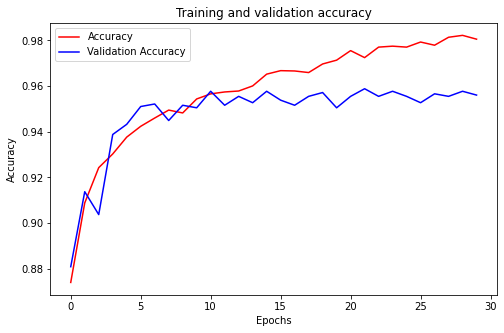

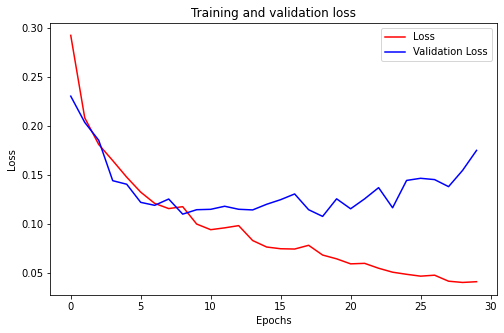

<Figure size 576x360 with 0 Axes>

In [101]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [83]:
# Evaluating the model on the training and testing set
score = model_nn_OD.evaluate(X_train_OD, y_train_OD, verbose=0)
print("Training Accuracy: ", score[1])

score = model_nn_OD.evaluate(X_test_OD, y_test_OD, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9782850742340088
Testing Accuracy:  0.9599332213401794


In [84]:
model_nn_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_nnmodel_OD.h5')

In [102]:
import tensorflow as tf
model_nn_OD = tf.keras.models.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_nnmodel_OD.h5')

In [85]:
X_train_OD[0].shape

(1460, 1)

In [87]:
predict = model_nn_OD.predict(X_train_OD[0].reshape(1, 1460, 1))

In [88]:
predict

array([[0.99999046]], dtype=float32)

In [97]:
import tensorflow as tf
model_nn_OC = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(1461, 1)),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
from keras.optimizers import SGD, Adam
opt = Adam(learning_rate=0.001)
model_nn_OC.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model_nn_OC.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 1460, 64)          192       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 730, 64)           0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 730, 64)           0         
_________________________________________________________________
dense_34 (Dense)             (None, 730, 64)           4160      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 729, 64)           8256      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 364, 64)           0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 364, 64)         

In [96]:
num_epochs = 20
batch = 50
history = model_nn_OC.fit(X_train_OC, y_train_OC, batch_size=batch, epochs=num_epochs, validation_data=(X_test_OC, y_test_OC), verbose=1)

Epoch 1/20
147/147 [==============================] - 117s 751ms/step - loss: 5.0694 - accuracy: 0.7030 - val_loss: 1.8321 - val_accuracy: 0.7611
Epoch 2/20
147/147 [==============================] - 111s 756ms/step - loss: 1.8008 - accuracy: 0.7275 - val_loss: 1.8331 - val_accuracy: 0.7501
Epoch 3/20
147/147 [==============================] - 111s 757ms/step - loss: 1.7533 - accuracy: 0.7328 - val_loss: 1.6996 - val_accuracy: 0.7594
Epoch 4/20
147/147 [==============================] - 111s 758ms/step - loss: 1.7090 - accuracy: 0.7417 - val_loss: 1.6944 - val_accuracy: 0.7387
Epoch 5/20
147/147 [==============================] - 111s 757ms/step - loss: 1.6606 - accuracy: 0.7492 - val_loss: 1.6845 - val_accuracy: 0.7507
Epoch 6/20
147/147 [==============================] - 111s 756ms/step - loss: 1.6278 - accuracy: 0.7571 - val_loss: 1.6085 - val_accuracy: 0.7687
Epoch 7/20
147/147 [==============================] - 112s 759ms/step - loss: 1.5916 - accuracy: 0.7578 - val_loss: 1.5792 -

KeyboardInterrupt: ignored

<Figure size 576x360 with 0 Axes>

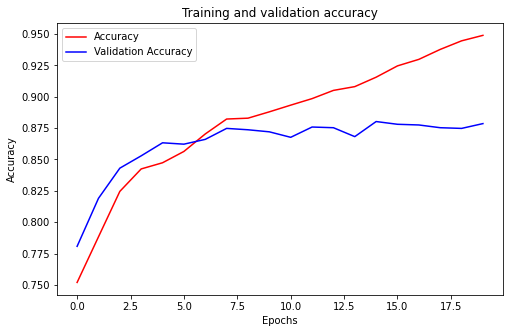

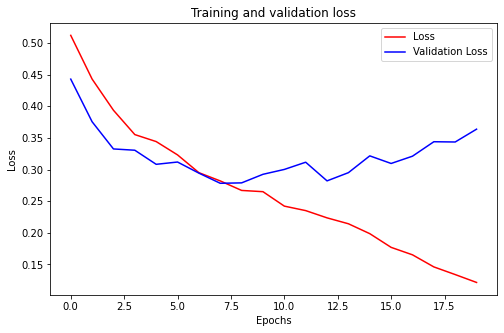

<Figure size 576x360 with 0 Axes>

In [92]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [93]:
model_nn_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/superpixel_nnmodel_OC.h5')

ValueError: ignored

# **1. Preprocessing** 
CLAHE dan/ atau homomorphic filtering

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 


# Read retinal image, CV2 menginput citra dengan channel BGR
src1 = cv2.imread("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/drishtiGS_018.png", 1) # DRISHTI
# src2 = cv2.imread("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/image3prime.tif", 1) # RIGA (sementara pakai drishti dulu)
src3 = cv2.imread("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/g0005.jpg", 1) # REFUGE (sementara pakai drishti dulu)

# Citra dirubah menjadi RGB karena plt.imshow menampilkan citra dengan susunan 
# channel RGB sedangkan cv2 membaca dengan urutan channel BGR
src1 = cv2.cvtColor(src1, cv2.COLOR_BGR2RGB)
src2 = cv2.cvtColor(src2, cv2.COLOR_BGR2RGB)
src3 = cv2.cvtColor(src3, cv2.COLOR_BGR2RGB)

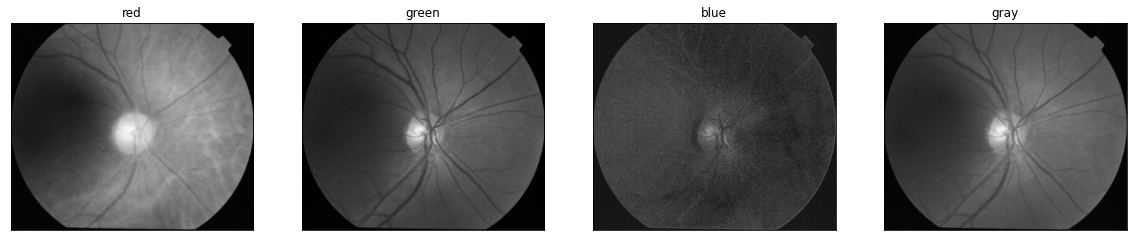

In [ ]:
green = src1[:, :, 1]
red = src1[:, :, 0]
blue = src1[:, :, 2]
gray = cv2.cvtColor(src1, cv2.COLOR_BGR2GRAY)

images = [red, green, blue, gray]
titles = ['red', 'green', 'blue', 'gray']
figure(images, titles, coloumn=4)

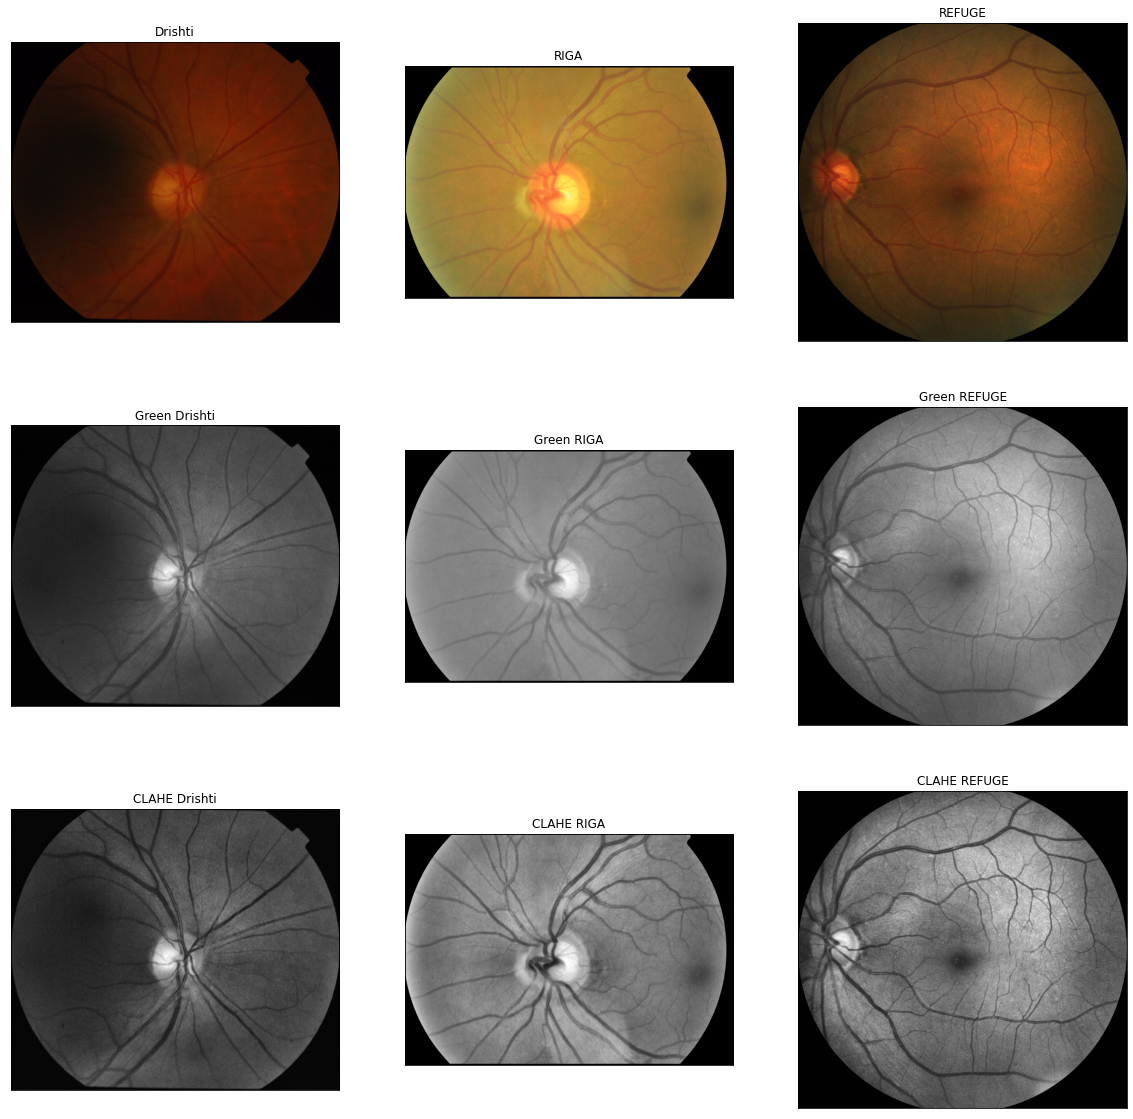

In [ ]:
# Extract green channel of image and convert it to grayscale
img1 = src1[:,:,1]
img2 = src2[:,:,1]
img3 = src3[:,:,1]

# Implementing CLAHE 
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
cl_img1 = clahe.apply(img1)
cl_img2 = clahe.apply(img2)
cl_img3 = clahe.apply(img3)

cl_image = [cl_img1, cl_img2, cl_img3]
gre_image = [img1, img2, img3]
src_image = [src1, src2, src3]

images = src_image + gre_image + cl_image
titles = ['Drishti', 'RIGA', 'REFUGE', 'Green Drishti', 'Green RIGA',
          'Green REFUGE', 'CLAHE Drishti', 'CLAHE RIGA', 'CLAHE REFUGE']

figure(images, titles)

# Input Ground Truth


In [ ]:
"""
# fungsi untuk mengkonversi groundtruth RIGA
def rigaGT(path, shape=None):
  import cv2
  import numpy as np
  from matplotlib import pyplot as plt 

  #coming soon
  mask = cv2.imread(path, 1)
  print(type(mask))
  h, w, _ = mask.shape
  
  idx = np.where(mask == [46, 49, 68])
  idx = list(zip(*idx))
  idx = np.array(idx)

  boundary = np.zeros([h, w], np.uint8)

  boundary[idx[:, 0], idx[:, 1]] = 255

  output = cv2.connectedComponentsWithStats(boundary, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output

  componentMask = (labels == 100).astype("uint8") * 255

  print((h, w))
  print(labels.shape)
  print(numLabels)
  plt.subplot(131), plt.imshow(boundary, cmap = 'gray')
  plt.subplot(132), plt.imshow(labels, cmap = 'gray')
  plt.subplot(133), plt.imshow(componentMask, cmap = 'gray')
  plt.show()
  

rigaGT("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/riga/Image3-1.tif")
"""


In [ ]:
gt_path = "/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/drishti/"

# Upload data ground truth dari dataset

#Drishti
OD_mask1_gt, OD_bound1_gt = drishtiGT(gt_path + "drishtiGS_018_ODAvgBoundary.txt", src1.shape) 
OC_mask1_gt, OC_bound1_gt  = drishtiGT(gt_path + "drishtiGS_018_CupAvgBoundary.txt", src1.shape)

# RIGA
# OD_mask2_gt, OD_bound2_gt  = drishtiGT(gt_path + "drishtiGS_036_ODAvgBoundary.txt", src2.shape) #rigaGT
# OC_mask2_gt, OC_bound2_gt  = drishtiGT(gt_path + "drishtiGS_036_CupAvgBoundary.txt", src2.shape)

# REFUGE
OD_mask3_gt, OC_mask3_gt, OD_bound3_gt, OC_bound3_gt  = refuGT("/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/tes image/GT/refuge/g0005.bmp") #refuGT




# **2. Lokalisasi OD**
1.   Bright region detection
2.   Template matching




**Bright Region Detection**



1. Otsu Thresholding
2. Eucledian Distance Map
3. Select max point in distance map
4. Extract Centroid






**Otsu Thresholding**

In [ ]:
# Get Otsu Threshold
ret1,_ = cv2.threshold(cl_img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,_ = cv2.threshold(cl_img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,_ = cv2.threshold(cl_img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cons = 8/3
# modified otsu thresholding
th1 = ret1*cons
th2 = ret2*cons
th3 = ret3*cons

_, otsu_img1 = cv2.threshold(cl_img1,th1,255,cv2.THRESH_BINARY)
_, otsu_img2 = cv2.threshold(cl_img2,th2,255,cv2.THRESH_BINARY)
_, otsu_img3 = cv2.threshold(cl_img3,th3,255,cv2.THRESH_BINARY)

otsu_image = [otsu_img1, otsu_img2, otsu_img3]
otsu_title = ["otsu 1", "otsu 2", "otsu 3"]

for a in range(3):
  plt.subplot(1,3, a+1), plt.imshow(otsu_image[a], cmap = 'gray')
  plt.title(otsu_title[a])
  plt.xticks([]), plt.yticks([])
plt.show()

NameError: ignored

**Eucledian distance map**

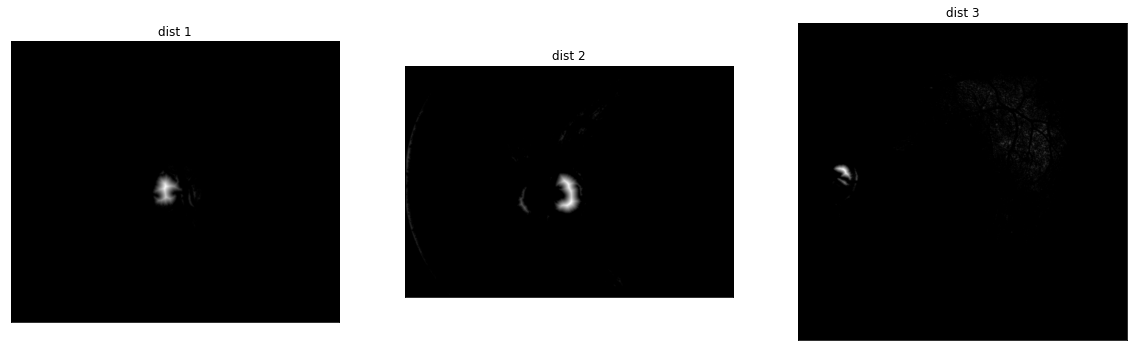

In [ ]:
dist_img1 = cv2.distanceTransform(otsu_img1, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
dist_img2 = cv2.distanceTransform(otsu_img2, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
dist_img3 = cv2.distanceTransform(otsu_img3, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

dist_image = [dist_img1, dist_img2, dist_img3]
dist_title = ["dist 1", "dist 2", "dist 3"]

for a in range(3):
  plt.subplot(1,3, a+1), plt.imshow(dist_image[a], cmap = 'gray')
  plt.title(dist_title[a])
  plt.xticks([]), plt.yticks([])
plt.show()

**Select max point in dist map function**

In [ ]:
maxima1 = maxima(dist_img1)
maxima2 = maxima(dist_img2)
maxima3 = maxima(dist_img3)

maxima_image = [maxima1, maxima2, maxima3]
maxima_title = ["maxima 1", "maxima 2", "maxima 3"]

figure(maxima_image, maxima_title)


Saran pengembangan :
1.  Gunakan seleksi blob

**Extract Cenroid of Bright Region**

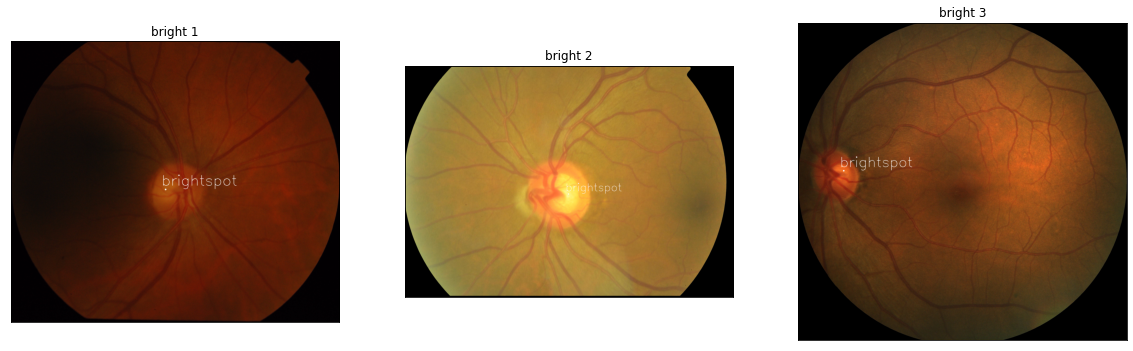

In [ ]:
maxima1 = cv2.convertScaleAbs(maxima1)
maxima2 = cv2.convertScaleAbs(maxima2)
maxima3 = cv2.convertScaleAbs(maxima3)

centroids1 = centroids(maxima1)
centroids2 = centroids(maxima2)
centroids3 = centroids(maxima3)

br_img1 = brightspot(centroids1, src1)
br_img2 = brightspot(centroids2, src2)
br_img3 = brightspot(centroids3, src3)

br_image = [br_img1, br_img2, br_img3]
br_title = ["bright 1", "bright 2", "bright 3"]

figure(br_image, br_title)



Saran pengembangan :
1. Gunakan bright fringe trimming

**Histogram Template Matching**


1.   Creation of template histogram
2.   Template matching



**Histogram Template Matching**

Vessel removal

# **3. Segmentasi OC dan OD**
1. Kmeans + Houghtransform (mvoulana et al)
2. Active disc + Houghtransform (kumar et al)
3. Superpixel classification (Cheng et al)

**Kmeans + Circle Hough Transform**

In [ ]:
OD_mask1, OC_mask1, OD_bound1, OC_bound1 = segmentasi_OC_OD_kmeans(ROI1)
OD_mask2, OC_mask2, OD_bound2, OC_bound2 = segmentasi_OC_OD_kmeans(ROI2)
OD_mask3, OC_mask3, OD_bound3, OC_bound3 = segmentasi_OC_OD_kmeans(ROI3)

**Active Disc + Hough Transform**

In [ ]:
# Coming soon


**Superpixel Segmentation**

In [ ]:
# Coming soon

In [ ]:
s = 600 # dummy

ODmask1 = resizeMask(centroid1, s, cl_img1.shape, OD_mask1)
OCmask1 = resizeMask(centroid1, s, cl_img1.shape, OC_mask1)
ODbound1 = resizeMask(centroid1, s, cl_img1.shape, OD_bound1)
OCbound1 = resizeMask(centroid1, s, cl_img1.shape, OC_bound1)

ODmask2 = resizeMask(centroid2, s, cl_img2.shape, OD_mask2)
OCmask2 = resizeMask(centroid2, s, cl_img2.shape, OC_mask2)
ODbound2 = resizeMask(centroid2, s, cl_img2.shape, OD_bound2)
OCbound2 = resizeMask(centroid2, s, cl_img2.shape, OC_bound2)

ODmask3 = resizeMask(centroid3, s, cl_img3.shape, OD_mask3)
OCmask3 = resizeMask(centroid3, s, cl_img3.shape, OC_mask3)
ODbound3 = resizeMask(centroid3, s, cl_img3.shape, OD_bound3)
OCbound3 = resizeMask(centroid3, s, cl_img3.shape, OC_bound3)

# Menampilkan boundary hasil segmentasi (biru) dan groundtruth (hijau)
segmentasiOD1 = drawMask(ODbound1, src1, tipe = 'biru')
segmentasiOD1 = drawMask(OD_bound1_gt, segmentasiOD1, tipe = 'hijau')

segmentasiOC1 = drawMask(OCbound1, src1, tipe = 'biru')
segmentasiOC1 = drawMask(OC_bound1_gt, segmentasiOC1, tipe = 'hijau')

segmentasiOD2 = drawMask(ODbound2, src2, tipe = 'biru')
# segmentasiOD2 = drawMask(OD_bound2_gt, segmentasiOD2, tipe = 'hijau')

segmentasiOC2 = drawMask(OCbound2, src2, tipe = 'biru')
# segmentasiOC2 = drawMask(OC_bound2_gt, segmentasiOC2, tipe = 'hijau')

segmentasiOD3 = drawMask(ODbound3, src3, tipe = 'biru')
segmentasiOD3 = drawMask(OD_bound3_gt, segmentasiOD3, tipe = 'hijau')

segmentasiOC3 = drawMask(OCbound3, src3, tipe = 'biru')
segmentasiOC3 = drawMask(OC_bound3_gt, segmentasiOC3, tipe = 'hijau')


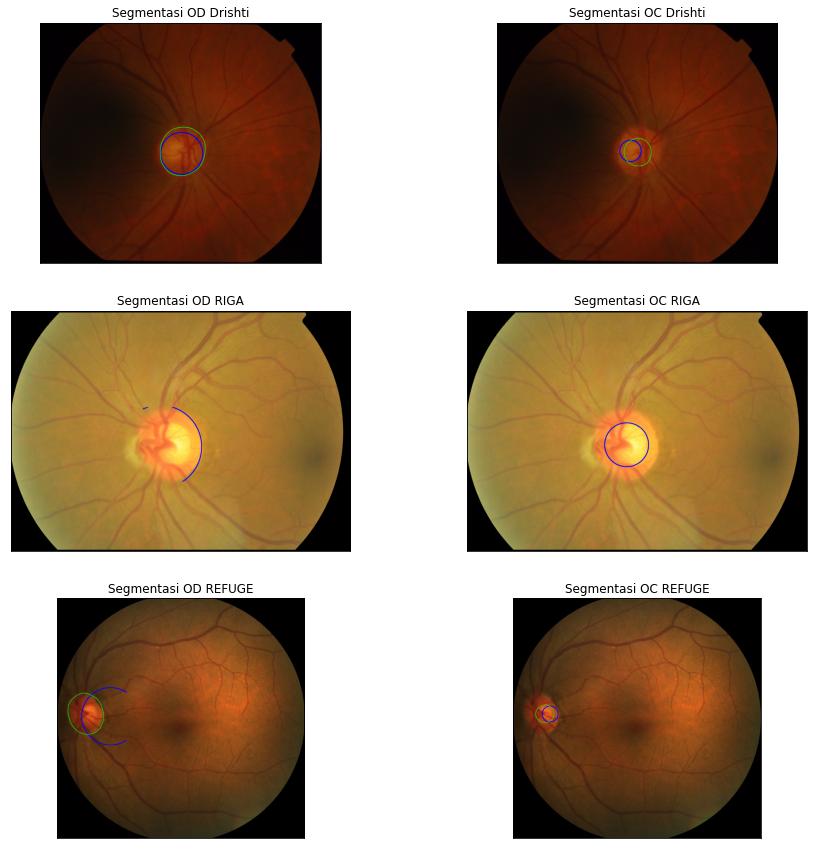

In [ ]:
images = [segmentasiOD1, segmentasiOC1, segmentasiOD2, segmentasiOC2,
          segmentasiOD3, segmentasiOC3]
titles = ['Segmentasi OD Drishti', 'Segmentasi OC Drishti','Segmentasi OD RIGA', 'Segmentasi OC RIGA',
          'Segmentasi OD REFUGE', 'Segmentasi OC REFUGE']

figure(images, titles, 2, 15)



**Metrik**

In [ ]:
lokalisasi1 = hitungPred(OD_mask3_gt, centroid3, tipe = 1)
print("Hasil lokalisasi : ", lokalisasi1)

Hasil lokalisasi :  True


In [ ]:
metrik_1 = [MetricCalc(OD_mask1_gt, ODmask1, tipe = 2), MetricCalc(OC_mask1_gt, OCmask1, tipe = 2)]
# metrik_2 = [MetricCalc(OD_mask2_gt, ODmask2, tipe = 2), MetricCalc(OC_mask2_gt, OCmask2, tipe = 2)]
metrik_3 = [MetricCalc(OD_mask3_gt, ODmask3, tipe = 2), MetricCalc(OC_mask3_gt, OCmask3, tipe = 2)]

print("OD 1:", metrik_1[0][2])
print("OC 1:", metrik_1[1][2])
#print("OD 2:", metrik_2[0][2])
#print("OC 2:", metrik_2[1][2])
print("OD 3:", metrik_3[0][2])
print("OC 3:", metrik_3[1][2])

OD 1: 0.88
OC 1: 0.59
OD 3: 0.38
OC 3: 0.61


In [ ]:
import pandas as pd

df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')
df.groupby(['tag']).size()

tag
Glaucoma     72
Normal      378
dtype: int64

In [ ]:
df.sample(n=10)

path  ...                                        path_OC_png
413  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
409  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
116  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
230  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
268  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
308  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
141  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
299  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
134  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...
366  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...  ...  /content/gdrive/My Drive/Drive Tugas Akhir/Dat...

[10 rows x 10 columns]

# **4. Ekstraksi Fitur**
1. CDR area
2. CDR vertikal
3. CDR horizontal
4. ISNT
5. RDR

# Ekstrak Ground Truth


In [ ]:
def ekstrak_groundtruth(path_OD, path_OC, shape, dataset):
  from PIL import Image
  from tqdm.notebook import tqdm
  from matplotlib import pyplot as plt
  import re
  import os

  iterates = len(path_OD)
  path_OD_png = []
  path_OC_png = []

  for i in tqdm(range(0, iterates), desc = "Number of GT that had been processed : "):
    old_file_OD = os.path.basename(path_OD[i])
    old_file_OC = os.path.basename(path_OC[i])   
    if (dataset[i].lower() == "drishti"):
      OD_mask_gt = drishtiGT(path_OD[i], shape[i])
      OC_mask_gt = drishtiGT(path_OC[i], shape[i])
      
    elif (dataset[i].lower() == "refuge"):
      OD_mask_gt, OC_mask_gt = refuGT(path_OD[i])


    new_file_OD = old_file_OD[:old_file_OD.index('.')] + '_OD_img.png'
    new_file_OC = old_file_OC[:old_file_OC.index('.')] + '_OC_img.png'
    path_OD_png.append(path_OD[i].replace(old_file_OD, new_file_OD))
    path_OC_png.append(path_OC[i].replace(old_file_OC, new_file_OC))
    
    OD_mask_gt = Image.fromarray(OD_mask_gt)
    OC_mask_gt = Image.fromarray(OC_mask_gt)
    
    OD_mask_gt.save(path_OD_png[-1])
    OC_mask_gt.save(path_OC_png[-1])
    
  return path_OD_png, path_OC_png

path_OD_png, path_OC_png =  ekstrak_groundtruth(path_gt_OD, path_gt_OC, shape, dataset)

In [ ]:
data_path_drishti= r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/images"
data_path_drishti_gt = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti/gt"
data_path_refuge = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/REFUGE/images"
data_path_refuge_gt = r"/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/REFUGE/gt"


Memindahkan file



In [ ]:
import os 
import shutil
import re

source = data_path_refuge_target
target = data_path_refuge_gt_target
#normal = [7,8,9,13,17,18,33,35,36,37,41,42,46,47,57,72,78,85,89,90,91,92,93,94,95,96,97,98,99,100,101]

for path, subdirs, files in os.walk(source):
   for file in files:
     if file.endswith(".bmp"):
      if "Glaucoma" in path:
        target_file = target + '/Glaucoma/'+ file
        source_path = os.path.join(path, file)
        shutil.move(source_path,target_file)
        print("{} has successfully moved".format(file))
      elif "Normal" in path:
        target_file = target + '/Normal/'+ file
        source_path = os.path.join(path, file)
        shutil.move(source_path,target_file)
        print("{} has successfully moved".format(file))
       

In [ ]:
import os
import cv2
import re

file_name = []
tag = []
full_path = []
path_gt_OD = []
path_gt_OC = []
disc_center = []
dataset = []
shape = []
# mengambil link citra drishti 

for path, subdirs, files in os.walk(data_path_drishti):
    for name in files:
          full_path.append(os.path.join(path, name)) 
          tag.append(path.split('/')[-1])        
          file_name.append(name)
          shape.append(cv2.imread(full_path[-1]).shape)
          dataset.append("drishti")

for path, subdirs, files in os.walk(data_path_drishti_gt, topdown = True):
    subdirs.sort()
    for name in files:
          if re.search(r'CupAvgBoundary.txt', name):
            path_gt_OC.append(os.path.join(path, name))

          elif re.search(r'ODAvgBoundary.txt', name):
            path_gt_OD.append(os.path.join(path, name))
        
          elif re.search(r'diskCenter.txt', name):
            dpath = os.path.join(path, name)
            file = open(dpath, 'r')
            diskcenter = file.readlines()
            y, x = diskcenter[0].split(' ')
            disc_center.append((int(x), int(y)))
            file.close() 

for path, subdirs, files in os.walk(data_path_refuge):
    subdirs.sort()
    files.sort()
    for name in files:
          full_path.append(os.path.join(path, name)) 
          tag.append(path.split('/')[-1])        
          file_name.append(name)
          shape.append(cv2.imread(full_path[-1]).shape)
          dataset.append("refuge")
          disc_center.append((-99, -99))

for path, subdirs, files in os.walk(data_path_refuge_gt):
    subdirs.sort()
    files.sort()
    for name in files:
          path_gt_OC.append(os.path.join(path, name))
          path_gt_OD.append(os.path.join(path, name))



In [ ]:
for i in range(len(full_path)):
  print(full_path[i].split('/')[-1])
  print(path_gt_OD[i].split('/')[-1])
  print(path_gt_OC[i].split('/')[-1])
  print()

In [ ]:
print(full_path[40])
print(path_gt_OD[40])

/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti-GS1_files/Drishti-GS1_files/Training/Images/Normal/drishtiGS_042.png
/content/gdrive/My Drive/Drive Tugas Akhir/Dataset/Drishti-GS1_files/Drishti-GS1_files/Training/GT/Normal/drishtiGS_057/AvgBoundary/drishtiGS_057_ODAvgBoundary.txt


In [ ]:
print(len(file_name))
print(len(tag))
print(len(full_path))
print(len(path_gt_OD))
print(len(path_gt_OC))
print(len(disc_center))
print(len(dataset))
print(len(shape))
print(len(path_OD_png))
print(len(path_OC_png))


450
450
450
450
450
450
450
450
450
450


In [ ]:
import pandas as pd

# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name, "path_OD": path_gt_OD,
                   "path_OC": path_gt_OC, "disc_center" : disc_center, "tag":tag, "dataset":dataset,
                   "shape":shape, "path_OD_png":path_OD_png, "path_OC_png":path_OC_png})

df.to_csv('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.csv')
df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')
df.groupby(['tag']).size()

NameError: ignored